## Packages and functions: correct labels, plot images, EDA

In [54]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, homogeneity_score, completeness_score
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import defaultdict

# Filter out specific warning types
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [123]:
def rotateM(x, flip_vertical=False):
    if flip_vertical:
        return np.fliplr(x)
    else:
        return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_mislabeled_images(indices, data, label, cmap='gray', message=''):
    assert len(indices) == len(label)
    plt.figure(figsize=(20, 6))
    for idx, i in enumerate(indices):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.title(label[idx])
    plt.savefig(f'imgs/data_mislabeled{message}.png')
    plt.show()

def plot_images(data, labels, label_names, key_='init', cmap='gray'):
    labels = labels.values.reshape(-1)
    num_images = min(len(data), 198)
    num_rows = 18
    num_cols = 11
    plt.figure(figsize=(30, 30))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_images:
                animal = label_names[labels[idx]]
                plt.subplot(18, 11, idx + 1)
                plt.imshow(rotateM(data.iloc[idx, :].values.reshape(64, 64)), cmap=cmap)
                plt.title(animal)

    plt.tight_layout()
    plt.savefig(f'imgs/{key_}/data.png')
    plt.show()

def correct_labels(data, true_dogs, true_cats):
    ''' 0 for cats and 1 for dogs'''
    for d in true_dogs:
        data.values[d] = 1
    for c in true_cats:
        data.values[c] = 0
    return data

ssc_mislabeled = [26, 54, 114, 117]
ssd_mislabeled = [8, 37, 112, 151, 176, 177]

In [56]:
def mean_animal(x, y):
    cat_indices = np.where(y == 0)[0]  
    dog_indices = np.where(y == 1)[0] 

    mean_cat = np.mean(x.iloc[cat_indices], axis=0)
    mean_dog = np.mean(x.iloc[dog_indices], axis=0)

    mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
    mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

    return mean_cat_image,  mean_dog_image

def plot_mean_images(x, y):
    ''' Mean Cat and Dog. '''
    mean_cat_image,  mean_dog_image = mean_animal(x, y)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image')
    plt.subplot(2, 2, 2)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image')
    plt.savefig(f'imgs/mean_animal.png')
    plt.show()

In [57]:
def print_label_counts(y):
    num_cats = np.count_nonzero(y == 0)
    num_dogs = np.count_nonzero(y == 1)
    print("Number of cats:", num_cats)
    print("Number of dogs:", num_dogs)

## Models and functions: constants, objects, training and analysis

### Hyper-parameters

In [58]:
# Random Forest
n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]

# Logistic Regression
penalty = ['l2']
C = [0.01, 0.1, 1, 10]

# KNN
n_neighbors = [3, 5, 7, 10]
cluster_nums = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# SVM
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.01, 0.1, 1, 10]

# MLP
hidden_layer_sizes = [(100,), (100, 50), (100, 75, 50), (200, ), (200, 100), (200, 150, 100)]

### Constants and objects

In [59]:
# Preprocessing
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

# labels
label_names = ['Cat', 'Dog']

# Scoring
scoring = 'accuracy'

# Models meta data dictionary for grid search
model_map = { 
  'rf': {
    'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'params': {
      'rf__n_estimators': n_estimators,
      'rf__max_depth': max_depth,
    },
    'name': 'Random Forest'
  },
  
  'lr': {
    'model': LogisticRegression(random_state=random_state, n_jobs=-1, solver='lbfgs', max_iter=1000),
    'params': {
      'lr__penalty': penalty,
      'lr__C': C,
    },
    'name': 'Logistic Regression'
  },
  
  'knn': {
    'model': KNeighborsClassifier(n_jobs=-1),
    'params': {
      'knn__n_neighbors': n_neighbors,
    },
    'name': 'K-Nearest Neighbors'
  },
  
  'svm': {
    'model': SVC(random_state=random_state),
    'params': {
      'svm__kernel': kernel,
      'svm__C': C,
    },
    'name': 'Support Vector Machine'
  },
  
  'mlp': {
    'model': MLPClassifier(random_state=random_state, early_stopping=True),
    'params': {
      'mlp__hidden_layer_sizes': hidden_layer_sizes,
    }, 
    'name': 'Multi-Layer Perceptron'
  },
}

### Functions: splits, grid search, classification report

In [60]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    ''' Split into train and test. Validation size is the percentage of train data that will be validation data. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

In [61]:
def run_grid_search(X_train, Y_train, model_key, model_info, scoring='accuracy', cv=3):
    best_params = {}
    best_cv_scores = {}
    best_models = {}
    
    model = model_info['model']
    params = model_info['params']
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_key, model)
    ])

    # Perform grid search
    grid_search_res = GridSearchCV(pipeline, params, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
    
    # Save best parameters and score
    best_params['model'] = grid_search_res.best_params_
    best_cv_scores['model'] = grid_search_res.best_score_
    best_models['model'] = grid_search_res.best_estimator_        
    
    return grid_search_res

In [62]:
def mislabeled_images(results, X, Y):
    # Get best parameters for each model
    best_parameters = {
        'knn': results['knn']['grid_search_res'].best_params_,
        'lr': results['lr']['grid_search_res'].best_params_,
        'svm': results['svm']['grid_search_res'].best_params_,
        'rf': results['rf']['grid_search_res'].best_params_,
        'mlp': results['mlp']['grid_search_res'].best_params_
    }

    # Best models after GridSearchCV for each model
    best_models = {
        'knn': KNeighborsClassifier(best_parameters['knn']['knn__n_neighbors']),
        'lr': LogisticRegression(C = best_parameters['lr']['lr__C'], penalty = best_parameters['lr']['lr__penalty']),
        'svm': SVC(C = best_parameters['svm']['svm__C'], kernel = best_parameters['svm']['svm__kernel']),
        'rf': RandomForestClassifier(n_estimators = best_parameters['rf']['rf__n_estimators'], max_depth = best_parameters['rf']['rf__max_depth']),
        'mlp': MLPClassifier(hidden_layer_sizes = best_parameters['mlp']['mlp__hidden_layer_sizes'])
    }

    # Initialize Repeated K-Fold
    n_splits = 3
    n_repeats = 10
    rskf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    # X and Y to np.array from dataframe
    X_array = np.array(X)
    Y_array = np.array(Y).ravel()

    # To keep track of mislabeling
    mislabel_records = {name: defaultdict(list) for name in best_models}

    # Train models and track mislabeling
    for train_index, test_index in rskf.split(X_array, Y_array):
        X_train, X_test = X_array[train_index], X_array[test_index]
        Y_train, Y_test = Y_array[train_index], Y_array[test_index]
        
        for name, model in best_models.items():
            model.fit(X_train, Y_train)
            y_pred = model.predict(X_test)
            
            # Track mislabels
            for idx, (true_label, pred_label) in enumerate(zip(Y_test, y_pred)):
                if true_label != pred_label:
                    mislabel_records[name][test_index[idx]].append(1)

    # Aggregate mislabeling results
    mislabeled = defaultdict(int)

    for name, mislabels in mislabel_records.items():
        for idx, errors in mislabels.items():
            mislabeled[idx] += sum(errors)

    # Sorting mislabeled based on the number of times they are mislabeled
    sorted_mislabeled = sorted(mislabeled.items(), key=lambda item: item[1], reverse=True)
    mislabeled_indices = [idx for idx, _ in sorted_mislabeled]
    
    # Plot mislabeled images
    print('---------------------------------------------------------------------------------------------------')
    print('Total mislabeling across all models')
    print('---------------------------------------------------------------------------------------------------')

    print(f"Mislabeled indices: {sorted_mislabeled[:5]}")
    subtitles = [f'Mislabeled {count} times' for _, count in sorted_mislabeled[:5]]
    plot_mislabeled_images(mislabeled_indices[:5], X, label=subtitles, message='_total_mislabeling')

    print('---------------------------------------------------------------------------------------------------')
    print('Mislabeling for each model')
    print('---------------------------------------------------------------------------------------------------')

    model_mislabeled = defaultdict(int)

    # Process mislabeling for each model
    for name, mislabels in mislabel_records.items():
        mislabeled = defaultdict(int)

        for idx, errors in mislabels.items():
            mislabeled[idx] += sum(errors)

        # Sorting mislabeled based on the number of times they are mislabeled
        sorted_mislabeled = sorted(mislabeled.items(), key=lambda item: item[1], reverse=True)

        mislabeled_indices = [idx for idx, _ in sorted_mislabeled]
        print(f'Mislabeling for model: {name}')

        # Plot mislabeled images
        print(f"Mislabeled indices: {sorted_mislabeled[:5]}")
        subtitles = [f'Mislabeled {count} times' for _, count in sorted_mislabeled[:5]]
        plot_mislabeled_images(mislabeled_indices[:5], X, label=subtitles, message=f'_{name}_mislabeling')

        # Store mislabeling results
        model_mislabeled[name] = mislabeled_indices[:10]

        print('---------------------------------------------------------------------------------------------------')

    print(f'Images mislabeled by models - count the number of models that mislabeled the top 10 images for each model')
    print('---------------------------------------------------------------------------------------------------')

    # Most common mislaled images in model_mislabeled dictionary
    model_mislabeled_count = defaultdict(int)
    for model, indices in model_mislabeled.items():
        for idx in indices:
            model_mislabeled_count[idx] += 1

    sorted_model_mislabeled = sorted(model_mislabeled_count.items(), key=lambda item: item[1], reverse=True)
    print(f"Mislabeled indices: {sorted_model_mislabeled[:5]}")
    subtitles = [f'Mislabeled by {count} models' for _, count in sorted_model_mislabeled[:5]]
    plot_mislabeled_images([idx for idx, _ in sorted_model_mislabeled[:5]], X, label=subtitles, message='_count_model_mislabeling')

# mis_images = mislabeled_images(results, X_cats_dogs, Y_cats_dogs)

In [63]:
def plot_confusion_matrix(Y_test, Y_pred, labels, model_name, key, flag_plot):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix for test data (model: {model_name})')
  plt.savefig(f'imgs/{key}/CM_{model_name}.png')
  if flag_plot:
    plt.show()
  
def show_classification_report(Y_test, Y_pred, model_name: str, key):
  print(f"Classification Report for test data (key: {key}, model: {model_name}) \n {classification_report(Y_test, Y_pred, target_names=label_names)}")

def plot_roc_curves(Y_test, model_predictions, model_names, key, flag_plot):
    plt.figure()
    
    for model_name, Y_pred in zip(model_names, model_predictions):
        fpr, tpr, _ = roc_curve(Y_test, Y_pred)
        roc_auc = auc(fpr, tpr)  # Calculate AUC score
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')  # Add AUC score to the label
    
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models (test data)')
    plt.legend(loc="lower right")
    plt.savefig(f'imgs/{key}/ROC_All_Models.png')
    if flag_plot:
        plt.show()

def plot_roc_curve(Y_test, Y_pred, model_name, key, flag_plot):
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)  # Calculate AUC score
  
  plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {roc_auc:.2f})')  # Add AUC score to the label
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name} (test data)')
  plt.legend()
  plt.savefig(f'imgs/{key}/ROC_{model_name}.png')
  if flag_plot:
    plt.show()

### Functions: part 1

In [96]:
def plot_feature_importance(results, X, Y, key, dim, sample_image, n_best=500):
    feat_importance_lr = []
    feat_importance_rf = []
    feat_importance_anova = []
    
    for model_key, model_info in results.items():
        # random forest case
        if model_key == 'rf':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_rf.append(model.named_steps[model_key].feature_importances_)
        # logistic regression case
        if model_key == 'lr':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_lr.append(np.abs(model.named_steps[model_key].coef_))
            
    # compute feature importance with anova test
    anova = SelectKBest(score_func=f_classif, k='all')
    anova.fit(X, Y.values.ravel())
    
    # Ensure feature importance arrays are flattened and have the correct length
    feat_importance_lr = np.array(feat_importance_lr).flatten()
    feat_importance_rf = np.array(feat_importance_rf).flatten()
    feat_importance_anova = np.array(anova.scores_)
    
    # Function to get top n features and pad the rest with zeros
    def get_top_n_features(importance, n):
        top_indices = np.argsort(importance)[-n:]
        top_importance = np.zeros_like(importance)
        top_importance[top_indices] = importance[top_indices]
        return top_importance
    
    # Get the top n features for each method
    feat_importance_lr = get_top_n_features(feat_importance_lr, n_best)
    feat_importance_rf = get_top_n_features(feat_importance_rf, n_best)
    feat_importance_anova = get_top_n_features(feat_importance_anova, n_best)

    # Compute the coordinates for each pixel
    coordinates = [(i, j) for i in range(dim) for j in range(dim)]
    x, y = zip(*coordinates)
    
    # Function to plot feature importances
    def plot_importance(ax, image, importance, title):
        ax.imshow(image, cmap='gray')   
        scatter = ax.scatter(x, y, c=importance, cmap='hot', s=10)
        plt.colorbar(scatter, ax=ax)
        ax.set_title(title)

    # Create subplots
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot feature importances
    plot_importance(axes[0], sample_image, feat_importance_rf, 'Random Forest Feature Importance')
    plot_importance(axes[1], sample_image, feat_importance_lr, 'Logistic Regression Feature Importance')
    plot_importance(axes[2], sample_image, feat_importance_anova, 'ANOVA Feature Importance')
    
    plt.tight_layout()
    plt.savefig(f'imgs/{key}/Feature_importance.png')
    plt.show()

In [65]:
def clustering(X_train, X_test, Y_train, Y_test, cluster_numbers=cluster_nums):
    results = []

    for n_clusters in cluster_numbers:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels_train = kmeans.fit_predict(X_train)
        cluster_labels_test = kmeans.predict(X_test)

        # Compute homogeneity and completeness for training data
        homogeneity_train = homogeneity_score(Y_train, cluster_labels_train)
        completeness_train = completeness_score(Y_train, cluster_labels_train)
        accuracy_score_train = accuracy_score(Y_train, cluster_labels_train)
        
        # Compute homogeneity and completeness for test data
        homogeneity_test = homogeneity_score(Y_test, cluster_labels_test)
        completeness_test = completeness_score(Y_test, cluster_labels_test)
        accuracy_score_test = accuracy_score(Y_test, cluster_labels_test)
        
        # Align cluster labels with class labels for training data
        aligned_labels_train = np.zeros_like(cluster_labels_train)
        for cluster in range(n_clusters):
            mask = (cluster_labels_train == cluster)
            majority_class = np.bincount(Y_train[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_train[mask] = majority_class
        
        # Recalculate homogeneity and completeness after alignment for training data
        aligned_homogeneity_train = homogeneity_score(Y_train, aligned_labels_train)
        aligned_completeness_train = completeness_score(Y_train, aligned_labels_train)
        accuracy_score_train_aligned = accuracy_score(Y_train, aligned_labels_train)
        
        # Align cluster labels with class labels for test data
        aligned_labels_test = np.zeros_like(cluster_labels_test)
        for cluster in range(n_clusters):
            mask = (cluster_labels_test == cluster)
            majority_class = np.bincount(Y_test[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_test[mask] = majority_class

        # Recalculate homogeneity and completeness after alignment for test data
        aligned_homogeneity_test = homogeneity_score(Y_test, aligned_labels_test)
        aligned_completeness_test = completeness_score(Y_test, aligned_labels_test)
        accuracy_score_test_aligned = accuracy_score(Y_test, aligned_labels_test)
        
        results.append({
            # "Cluster Number": n_clusters,
            # "Train Homogeneity": homogeneity_train,
            # "Train Completeness": completeness_train,
            # "Train Aligned Homogeneity": aligned_homogeneity_train,
            # "Train Aligned Completeness": aligned_completeness_train,
            # "Test Homogeneity": homogeneity_test,
            # "Test Completeness": completeness_test,
            # "Test Aligned Homogeneity": aligned_homogeneity_test,
            # "Test Aligned Completeness": aligned_completeness_test
            "Train Accuracy": accuracy_score_train,
            "Train Aligned Accuracy": accuracy_score_train_aligned,
            "Test Accuracy": accuracy_score_test,
            "Test Aligned Accuracy": accuracy_score_test_aligned
        })
    
    return results

### Functions: part 2

In [85]:
def plot_sample_image_with_grid(mean_animal, type='mean_animal'):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_animal, cmap='gray')
    plt.title(f'{type}')
    plt.subplot(1, 2, 2)
    plt.imshow(mean_animal, cmap='gray')
    plt.title(f'{type} with Grid')
    for i in range(1, 4):
        plt.axhline(i * 16, color='r', linestyle='--')
        plt.axvline(i * 16, color='r', linestyle='--')
        plot_grid_with_nums()
    plt.savefig(f'imgs/{type}.png')
    plt.show()

def plot_grid_with_nums():
    for row in range(3, -1, -1):
        for col in range(3, -1, -1):
            plt.text(col * 16 + 3, row * 16 + 3, str((3 - col) * 4 + row), color='r')

def blocks_datasets(dataset):
    """ 16 datasets, each representing a block. """
    blocks = []  
    for row in range(4): 
        for col in range(4):  
            # pixel/feature indices corresponding to the block
            block_indices = [] 
            for i in range(64):  
                for j in range(64): 
                    # add the pixel belongs to the current block
                    if (i // 16 == row) and (j // 16 == col):
                        # calculate index of the pixel
                        block_indices.append(i * 64 + j) 
            blocks.append(dataset[:, block_indices])
    return blocks

# plot image and block 
def plot_blocks(dataset, block_dataset):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(rotateM(dataset.iloc[3, :].values.reshape(64, 64)), cmap='gray')
    # define picture
    img = 3
    c = 2
    for i in [1, 2, 3, 4, 5, 6]:
        plt.subplot(2, 3, c)
        plt.imshow(rotateM(block_dataset[i][img].reshape(16, 16)), cmap='gray')
        c = c + 1
    plt.show()

def flip_half_images_upside_down(X, Y):
    ''' Flip half of the images (reorder columns for half of the dataset).'''
    # cats and dogs random selection
    cat_indices = np.where(Y == 0)[0]
    dog_indices = np.where(Y == 1)[0]
    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)
    # 44 cats and 45 dogs
    cat_indices_to_flip = cat_indices[:44]
    dog_indices_to_flip = dog_indices[:45]

    X_flipped = X.copy()
    # flatten result of flipped images
    for idx in cat_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()

    for idx in dog_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()
        
    return X_flipped
    

## Main processes

In [67]:
def process_model(model_key, model_info, X_train, X_test, Y_train, Y_test, key, scoring='accuracy'):
    ''' Best parameters for a given algorithm. '''
    # grid search to get best model/parameters for given algorithm
    grid_search_res = run_grid_search(X_train, Y_train, model_key, model_info)
    Y_test_pred = grid_search_res.predict(X_test)
    
    # metrics on the test data
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_f1_score = f1_score(Y_test, Y_test_pred, average='macro')
    test_roc_auc_score = roc_auc_score(Y_test, Y_test_pred)
        
    # prepare log messages
    log_messages = [
        f'Experiment: {key}\n'
        f"Best parameters found for {model_info['name']}: {grid_search_res.best_params_}",
        f"Best CV {scoring} score: {grid_search_res.best_score_}",
        f'Model: {model_info["name"]}, test accuracy score: {test_accuracy}, test f1 Score: {test_f1_score}',
    ]

    # return info
    return {
        'model_key': model_key,
        'model_name': model_info["name"], 
        'grid_search_res': grid_search_res, 
        'test_accuracy': test_accuracy, 
        'test_f1_score': test_f1_score,
        'test_roc_auc_score': test_roc_auc_score,
        'Y_test_pred': Y_test_pred,
        'log_messages': log_messages,
    }



def show_results_summary(results, key='init'):
    # Print results summary in a tabular format (using pandas DataFrame)
    results_summary = []
    for _, result in results.items():
        results_summary.append({
            'Model': result['model_name'],
            'CV accuracy': result['grid_search_res'].best_score_,
            'Test Accuracy': result['test_accuracy'],
            'Test f1 score': result['test_f1_score'],
            'Test ROC AUC score': result['test_roc_auc_score'],
        })
         
    results_df = pd.DataFrame(results_summary)
    results_df.columns = ['Model', 'CV accuracy', 'Test Accuracy', 'Test f1 score', 'Test ROC AUC score']
    results_df.index = results_df['Model']
    results_df.drop(columns=['Model'], inplace=True)
    results_df = results_df.T

    display(results_df)

In [68]:
def show_blockresults_summary(results):
    # Define the model names
    model_names = list(results[0]['results'].keys())
    
    # Define the metrics and blocks
    metrics = ['CV accuracy', 'Test Accuracy', 'Test f1 score', 'Test ROC AUC score']
    blocks = range(len(results)) 
    
    # Create a MultiIndex for the rows
    index = pd.MultiIndex.from_product([blocks, metrics], names=['Block', 'Metric'])
    
    # Create an empty DataFrame with the appropriate structure
    results_df = pd.DataFrame(index=index, columns=model_names)
    
    # Fill the DataFrame with the results
    for block_idx, block_result in enumerate(results):
        for model_key, result in block_result['results'].items():
            results_df.loc[(block_idx, 'CV accuracy'), model_key] = result['grid_search_res'].best_score_
            results_df.loc[(block_idx, 'Test Accuracy'), model_key] = result['test_accuracy']
            results_df.loc[(block_idx, 'Test f1 score'), model_key] = result['test_f1_score']
            results_df.loc[(block_idx, 'Test ROC AUC score'), model_key] = result['test_roc_auc_score']
    
    # change the columns names to ['K-Nearest Neighbors', 'Logistic Regression', 'Support Vector Machine', 'Multi-Layer Perceptron', 'Random Forest']
    results_df.columns = ['K-Nearest Neighbors', 'Logistic Regression', 'Support Vector Machine', 'Multi-Layer Perceptron', 'Random Forest']
    # Display the DataFrame
    #display(results_df)
    print(results_df)

In [69]:
def get_best_models(results):
    ''' Get the best models/algorithms given results dictionaries. '''
    best_accuracy = -1
    best_f1_score = -1
    best_accuracy_model = None
    best_f1_score_model = None
    
    for model_key, result in results.items():
        if result['test_accuracy'] > best_accuracy:
            best_accuracy = result['test_accuracy']
            best_accuracy_model = result
            
        if result['test_f1_score'] > best_f1_score:
            best_f1_score = result['test_f1_score']
            best_f1_score_model = result
    
    return {
        'best_accuracy_model': best_accuracy_model,
        'best_f1_score_model': best_f1_score_model
    }

In [120]:
def main_parallel(model_map, X, Y, key, flag_plot=True, prints=True, best_model_metric='f1_score'):
    ''' best_model_metric can be f1_score or accuracy (of the test data)'''
    results = {} # keys are model keys and values are results dictionaries
    model_predictions = []
    model_names = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # split dataset
        X_train, X_test, Y_train, Y_test = splits(X, Y)
        
        futures = {}
        for model_key, model_info in model_map.items():
            future = executor.submit(process_model, model_key, model_info, X_train, X_test, Y_train, Y_test, key)
            futures[future] = model_key
        
        for future in concurrent.futures.as_completed(futures):
            model_key = futures[future]
            result = future.result()
            results[model_key] = result

        # Access the best models
        best_models = get_best_models(results)
        best_model = best_models[f'best_{best_model_metric}_model'] 

        if prints:   
            # print results summary
            if key == 'init' or 'block' in key:
                with print_lock:
                    print('\n\n**************************************************')
                    print('**RESULTS SUMMARY**\n')
                    show_results_summary(results)
                    print('**************************************************\n\n')
                    mislabeled_images(results, X, Y)
                    
            # print results for each model
            for _, result in results.items():
                # log results
                with print_lock:
                    
                    print('--------------------------------------------------')
                    for message in result['log_messages']:
                        print(message)
                    plot_confusion_matrix(Y_test, result['Y_test_pred'], label_names, result['model_name'], key, flag_plot)
                    plot_roc_curve(Y_test, result['Y_test_pred'], result['model_name'], key, flag_plot)
                    show_classification_report(Y_test, result['Y_test_pred'], result['model_name'], key)
                    print('--------------------------------------------------\n\n')
                    model_predictions.append(result['Y_test_pred'])
                    model_names.append(result['model_name'])

        else:
            if key != 'flipped':
                with print_lock:     
                    print('--------------------------------------------------')
                    print(f"Best Model by {best_model_metric} for {key}:")
                    for message in best_model['log_messages']:
                        print(message)

        plot_roc_curves(Y_test, model_predictions, model_names, key, flag_plot)
        plot_images(X_test, pd.DataFrame(best_model['Y_test_pred']), label_names={0: "cat", 1: "dog"}, key_=key, cmap='gray')
                    
    return results, best_model

In [71]:
def get_results_blocks(model_map, X, Y, key, flag=False, flag_plot=True, prints=True):
    X_cats_dogs_blocks = blocks_datasets(X.values)
    if flag:
        plot_blocks(X, X_cats_dogs_blocks)
    
    results_blocks = []

    for index, X_block in enumerate(X_cats_dogs_blocks):
        results = {}
        results['block'] = X_block
        results['results'], results['best_model'] = main_parallel(model_map, X_block, Y, f"block_{index}", flag_plot, prints)  
        results_blocks.append(results)

    return results_blocks

In [72]:
def get_top_blocks(results_blocks, top_n=3):
    # Sort the results blocks by the best F1 score in descending order
    sorted_blocks = sorted(results_blocks, key=lambda x: x['best_model']['test_f1_score'], reverse=True)
    top_blocks = sorted_blocks[:top_n]
    # Print information
    for i, block in enumerate(top_blocks):
        print(f"Top Block {i+1} with highest F1 score:")
        print(f"Best F1 Score: {block['best_model']['test_f1_score']}")
        print("Additional information about the best model:")
        for message in block['best_model']['log_messages']:
            print(message)
        print("--------------------------------------------------\n")
    return top_blocks

## Read data and work on it

In [73]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

Y_cats_dogs = correct_labels(Y_cats_dogs, true_dogs = [26, 54, 114, 117], true_cats = [8, 37, 112, 151, 176, 177])

#plot_mislabeled_images(ssc_mislabeled, X_cats_dogs, label="cat") 
#plot_images(X_cats_dogs, Y_cats_dogs, {0: "cat", 1: "dog"}, key_='init')
#plot_mean_images(X_cats_dogs, Y_cats_dogs)
#print_label_counts(Y_cats_dogs)

### 1.a Comparison of classifiers

In [89]:
mean_cat_image, mean_dog_image = mean_animal(X_cats_dogs, Y_cats_dogs)



**************************************************
**RESULTS SUMMARY**



Model               K-Nearest Neighbors  Logistic Regression  \
CV accuracy                    0.797412             0.873488   
Test Accuracy                  0.800000             0.825000   
Test f1 score                  0.791667             0.822222   
Test ROC AUC score             0.800000             0.846667   

Model               Support Vector Machine  Random Forest  \
CV accuracy                       0.898645       0.797533   
Test Accuracy                     0.875000       0.850000   
Test f1 score                     0.871051       0.843750   
Test ROC AUC score                0.886667       0.853333   

Model               Multi-Layer Perceptron  
CV accuracy                       0.854015  
Test Accuracy                     0.800000  
Test f1 score                     0.795396  
Test ROC AUC score                0.813333

**************************************************


---------------------------------------------------------------------------------------------------
Total mislabeling across all models
---------------------------------------------------------------------------------------------------
Mislabeled indices: [(78, 49), (85, 49), (113, 47), (69, 43), (58, 42)]


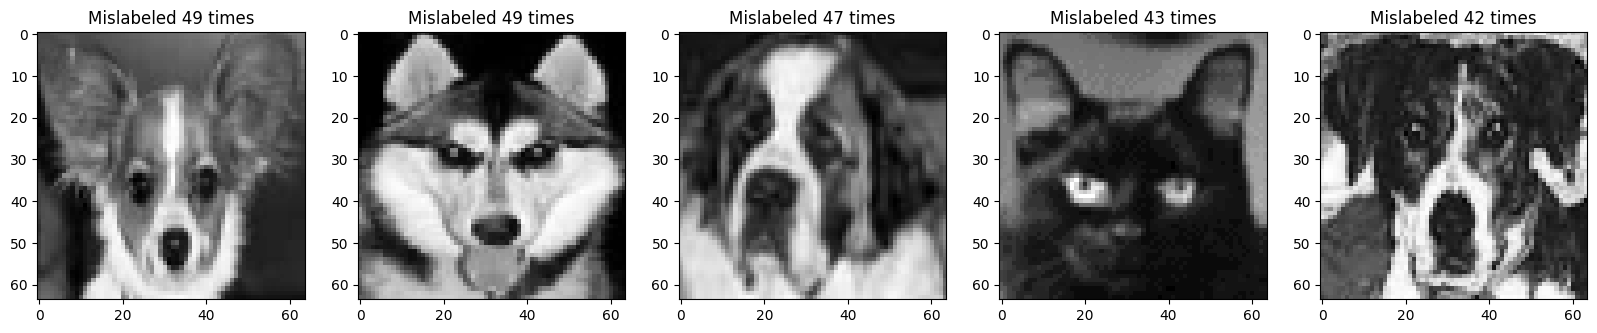

---------------------------------------------------------------------------------------------------
Mislabeling for each model
---------------------------------------------------------------------------------------------------
Mislabeling for model: knn
Mislabeled indices: [(69, 10), (78, 10), (85, 10), (113, 10), (147, 10)]


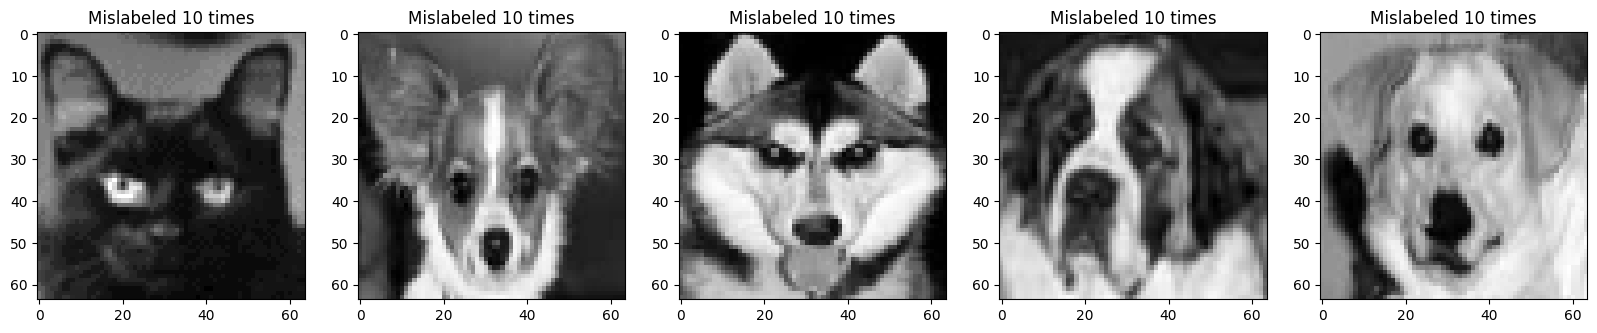

---------------------------------------------------------------------------------------------------
Mislabeling for model: lr
Mislabeled indices: [(12, 10), (78, 10), (85, 10), (113, 10), (47, 10)]


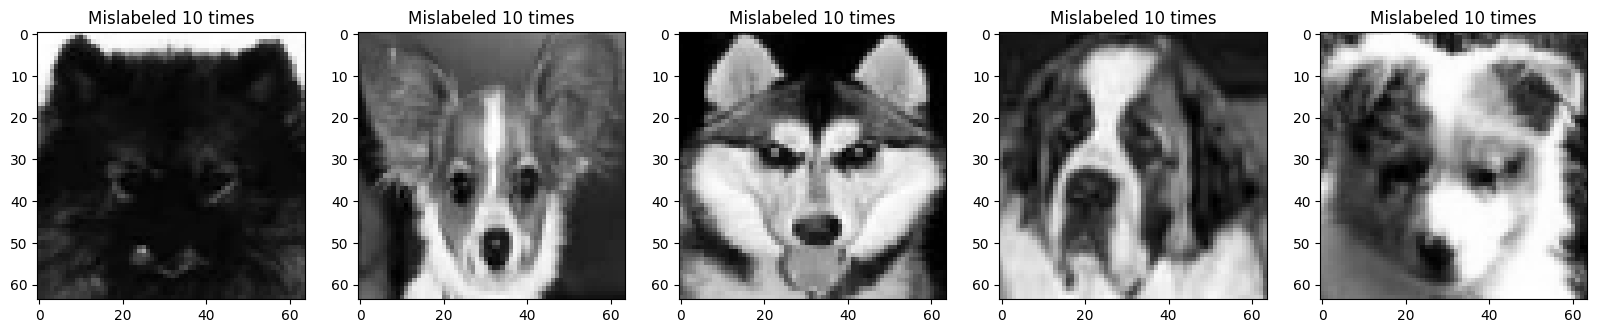

---------------------------------------------------------------------------------------------------
Mislabeling for model: svm
Mislabeled indices: [(69, 10), (78, 10), (85, 10), (113, 10), (93, 10)]


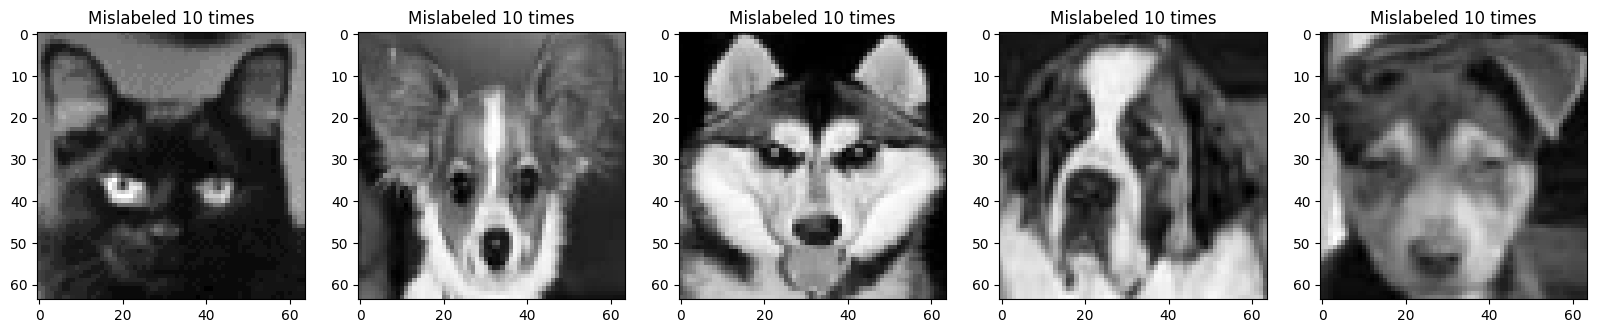

---------------------------------------------------------------------------------------------------
Mislabeling for model: rf
Mislabeled indices: [(78, 10), (85, 10), (137, 10), (93, 10), (108, 10)]


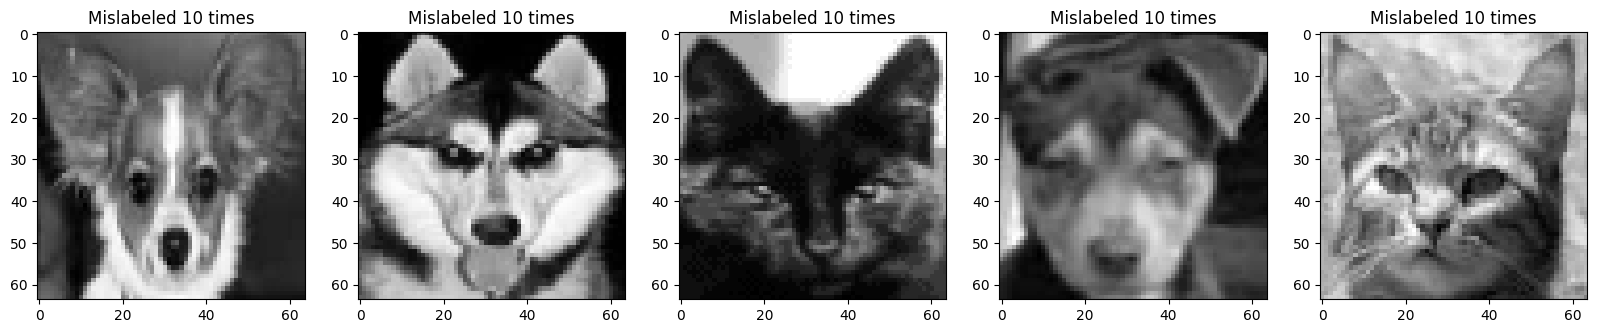

---------------------------------------------------------------------------------------------------
Mislabeling for model: mlp
Mislabeled indices: [(171, 10), (12, 9), (78, 9), (85, 9), (168, 9)]


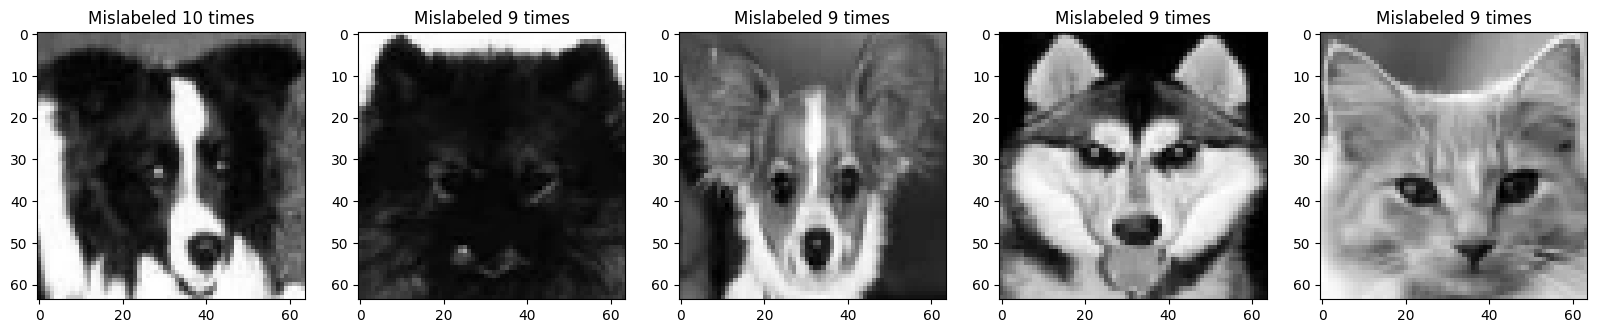

---------------------------------------------------------------------------------------------------
Images mislabeled by models - count the number of models that mislabeled the top 10 images for each model
---------------------------------------------------------------------------------------------------
Mislabeled indices: [(78, 5), (85, 5), (93, 4), (69, 3), (113, 3)]


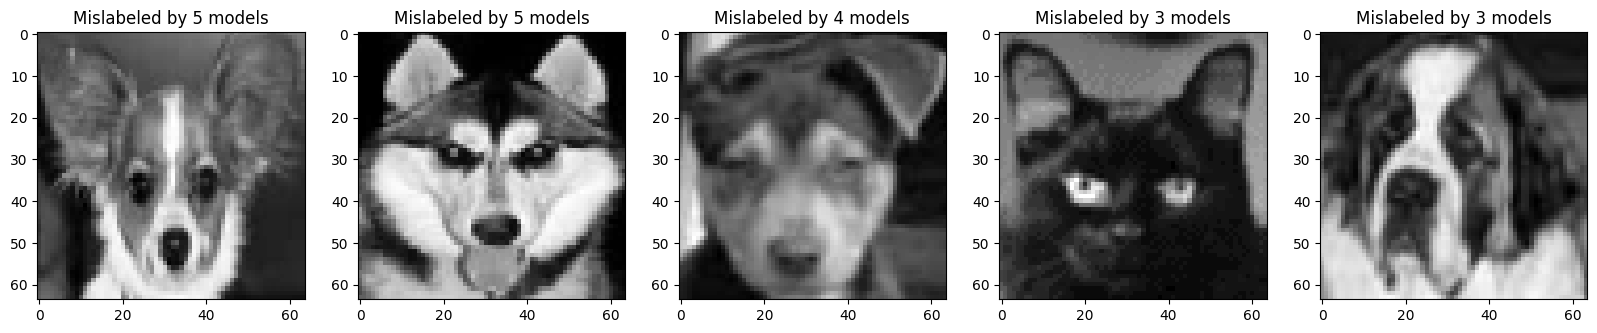

--------------------------------------------------
Experiment: init
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 3}
Best CV accuracy score: 0.7974117077890662
Model: K-Nearest Neighbors, test accuracy score: 0.8, test f1 Score: 0.7916666666666667


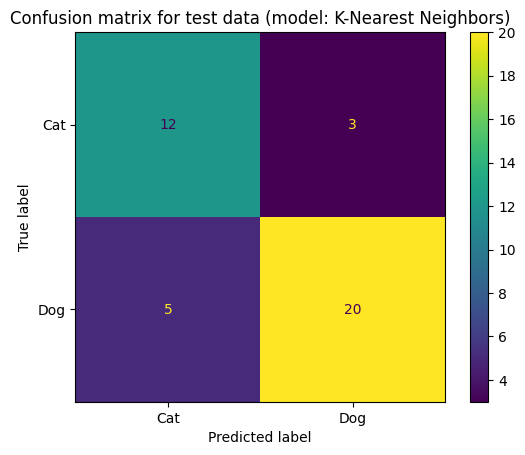

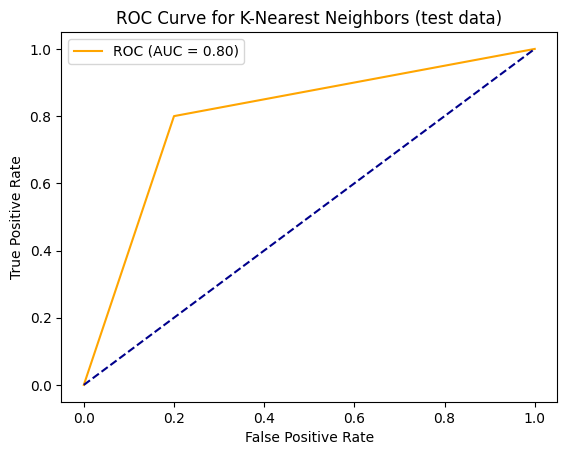

Classification Report for test data (key: init, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.71      0.80      0.75        15
         Dog       0.87      0.80      0.83        25

    accuracy                           0.80        40
   macro avg       0.79      0.80      0.79        40
weighted avg       0.81      0.80      0.80        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.8734881470730528
Model: Logistic Regression, test accuracy score: 0.825, test f1 Score: 0.8222222222222222


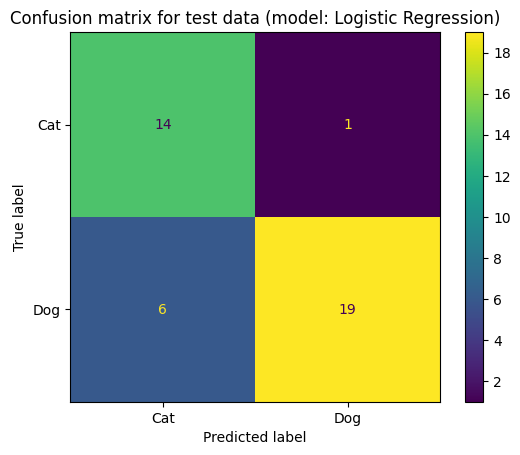

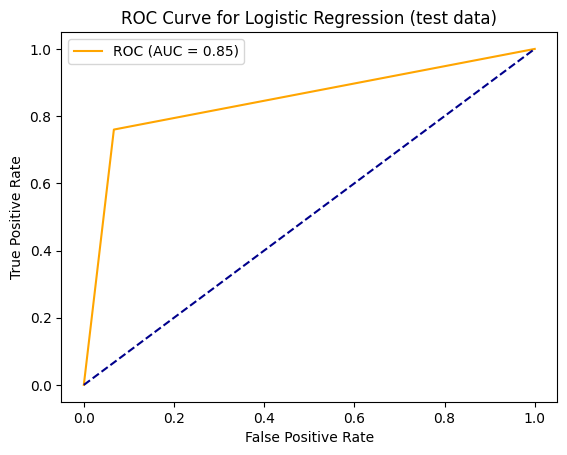

Classification Report for test data (key: init, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.70      0.93      0.80        15
         Dog       0.95      0.76      0.84        25

    accuracy                           0.82        40
   macro avg       0.82      0.85      0.82        40
weighted avg       0.86      0.82      0.83        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8986453797774553
Model: Support Vector Machine, test accuracy score: 0.875, test f1 Score: 0.871050934880722


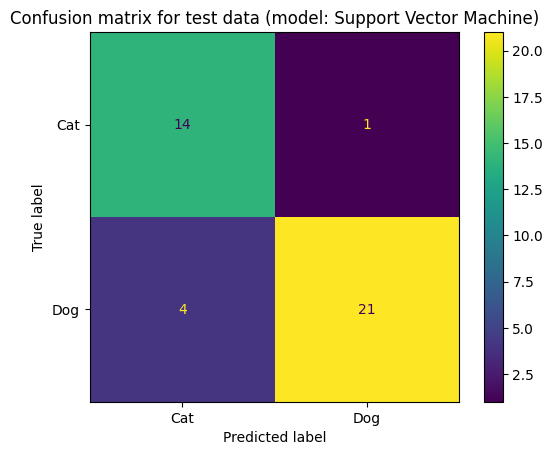

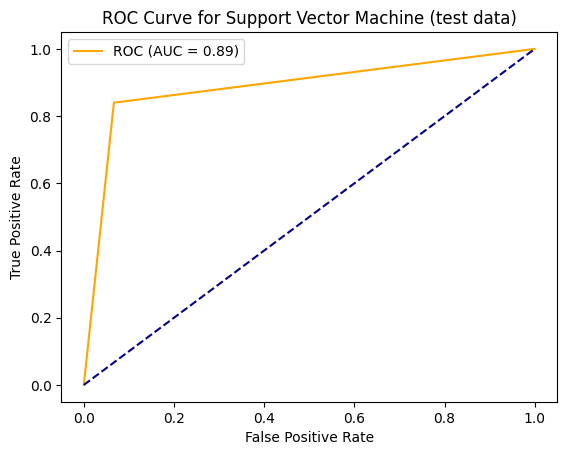

Classification Report for test data (key: init, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.78      0.93      0.85        15
         Dog       0.95      0.84      0.89        25

    accuracy                           0.88        40
   macro avg       0.87      0.89      0.87        40
weighted avg       0.89      0.88      0.88        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 150}
Best CV accuracy score: 0.7975326560232222
Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.84375


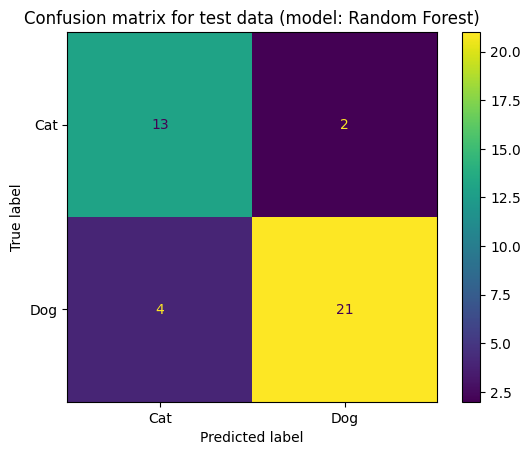

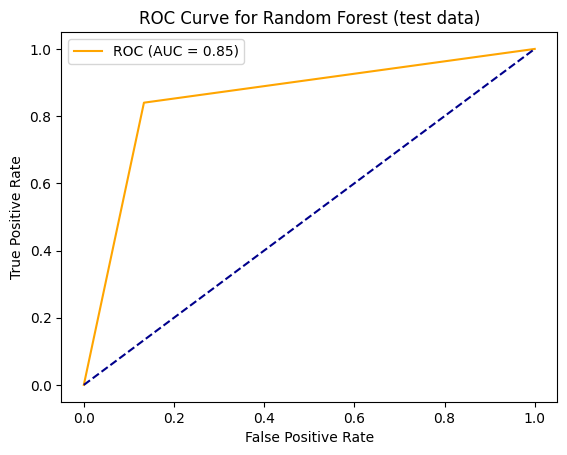

Classification Report for test data (key: init, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.76      0.87      0.81        15
         Dog       0.91      0.84      0.88        25

    accuracy                           0.85        40
   macro avg       0.84      0.85      0.84        40
weighted avg       0.86      0.85      0.85        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.8540154813739719
Model: Multi-Layer Perceptron, test accuracy score: 0.8, test f1 Score: 0.7953964194373402


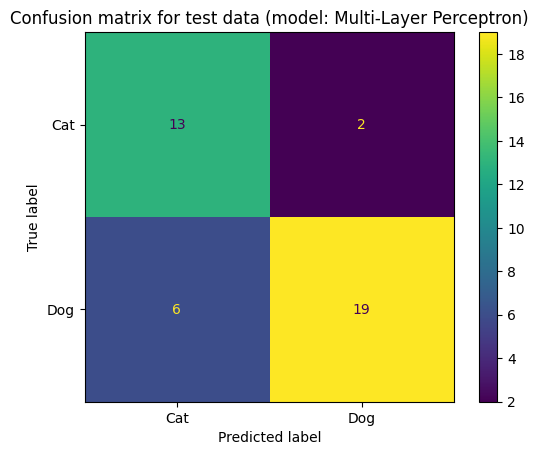

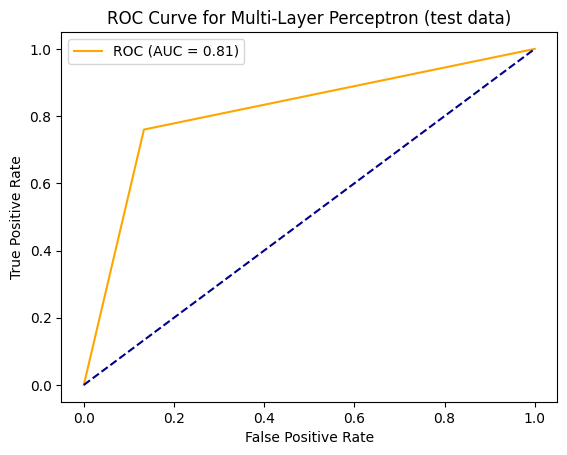

Classification Report for test data (key: init, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.68      0.87      0.76        15
         Dog       0.90      0.76      0.83        25

    accuracy                           0.80        40
   macro avg       0.79      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40

--------------------------------------------------




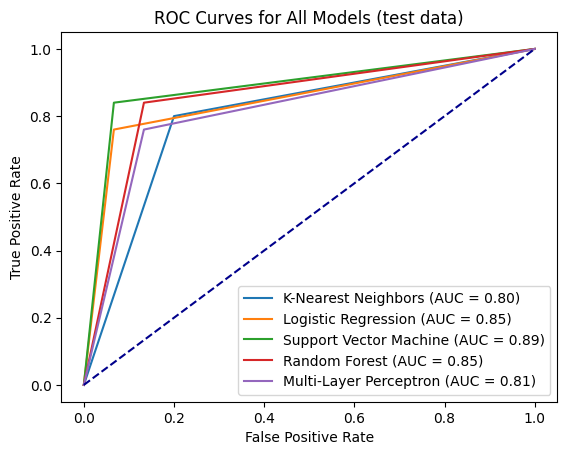

In [99]:
results, _ = main_parallel(model_map, X_cats_dogs, Y_cats_dogs, key='init', flag_plot=True)

### 1.b Feature importance methods

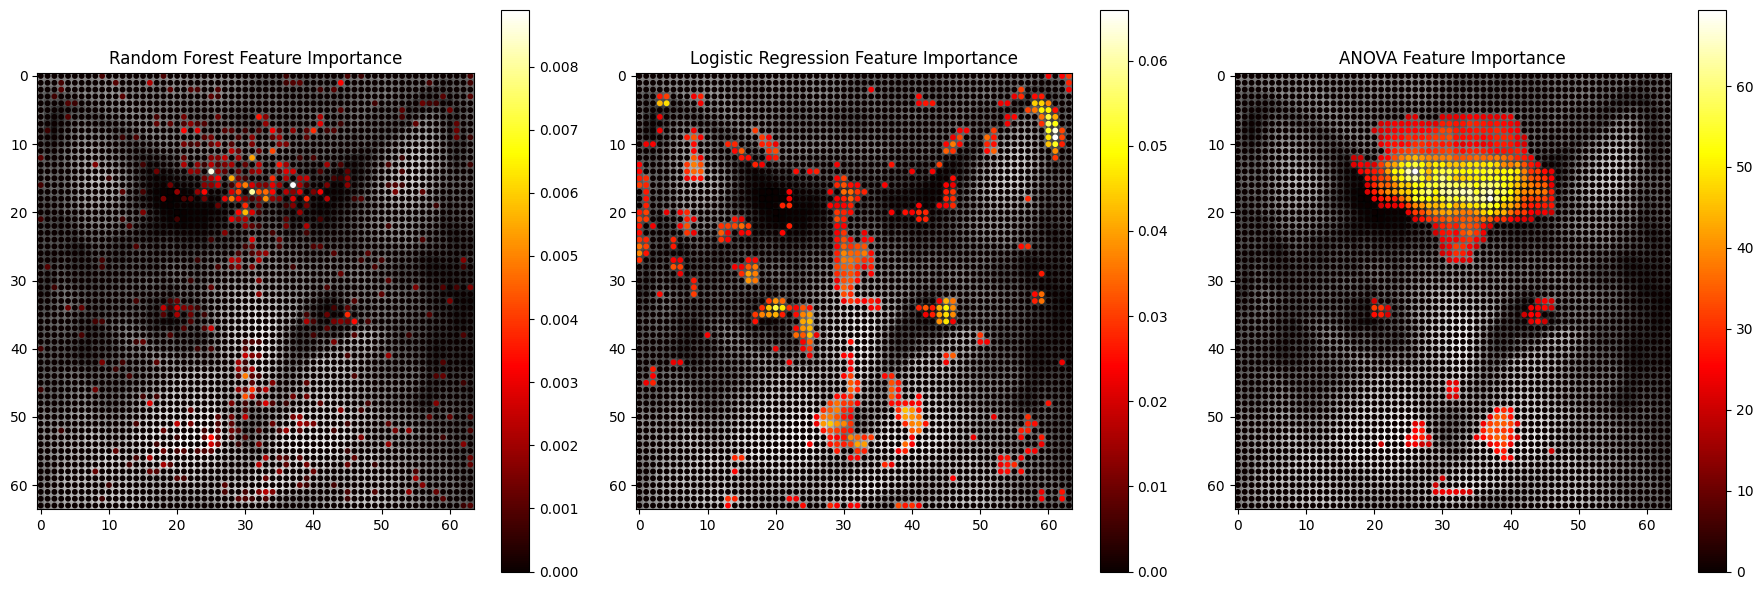

In [100]:
plot_feature_importance(results, X_cats_dogs, Y_cats_dogs, key='init', dim=64, sample_image=mean_dog_image)

### 1.c Clustering

In [76]:
#X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs)
#clustering(X_train, X_test, np.ravel(Y_train), np.ravel(Y_test), cluster_numbers = cluster_nums)

### 2.b Results for blocks

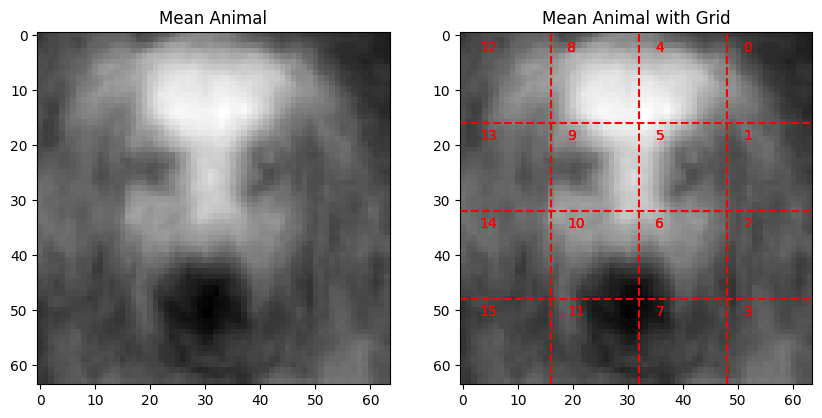

In [87]:
plot_sample_image_with_grid(mean_dog_image, 'mean_dog')

2024-05-22 15:04:04,076 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_0:
Experiment: block_0
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 100}
Best CV accuracy score: 0.8162796323173681
Model: Random Forest, test accuracy score: 0.825, test f1 Score: 0.8043326345213138


2024-05-22 15:04:12,553 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_1:
Experiment: block_1
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7022254475084663
Model: Support Vector Machine, test accuracy score: 0.725, test f1 Score: 0.6925227113906359


2024-05-22 15:04:21,276 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_2:
Experiment: block_2
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 100)}
Best CV accuracy score: 0.5884131591678762
Model: Multi-Layer Perceptron, test accuracy score: 0.65, test f1 Score: 0.6491228070175439


2024-05-22 15:04:29,743 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_3:
Experiment: block_3
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'linear'}
Best CV accuracy score: 0.6263909046927915
Model: Support Vector Machine, test accuracy score: 0.7, test f1 Score: 0.6875


2024-05-22 15:04:37,993 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_4:
Experiment: block_4
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7027092404450895
Model: Logistic Regression, test accuracy score: 0.725, test f1 Score: 0.7234443746071653


2024-05-22 15:04:47,029 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_5:
Experiment: block_5
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8288582486695694
Model: Support Vector Machine, test accuracy score: 0.825, test f1 Score: 0.819471308833011


2024-05-22 15:04:55,345 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_6:
Experiment: block_6
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7718916303821964
Model: Logistic Regression, test accuracy score: 0.775, test f1 Score: 0.7678916827852997


2024-05-22 15:05:03,288 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_7:
Experiment: block_7
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.6903725205611998
Model: Support Vector Machine, test accuracy score: 0.725, test f1 Score: 0.7163120567375887


2024-05-22 15:05:11,813 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_8:
Experiment: block_8
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7594339622641509
Model: Support Vector Machine, test accuracy score: 0.8, test f1 Score: 0.797979797979798


2024-05-22 15:05:19,856 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_9:
Experiment: block_9
Best parameters found for Random Forest: {'rf__max_depth': 3, 'rf__n_estimators': 50}
Best CV accuracy score: 0.733913884857281
Model: Random Forest, test accuracy score: 0.775, test f1 Score: 0.7714285714285715


2024-05-22 15:05:27,993 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_10:
Experiment: block_10
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7532656023222061
Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.8465473145780051


2024-05-22 15:05:37,340 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_11:
Experiment: block_11
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7148040638606675
Model: Support Vector Machine, test accuracy score: 0.85, test f1 Score: 0.84375


2024-05-22 15:05:45,450 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_12:
Experiment: block_12
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7653604257377843
Model: Random Forest, test accuracy score: 0.775, test f1 Score: 0.7714285714285715


2024-05-22 15:05:53,998 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_13:
Experiment: block_13
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 100}
Best CV accuracy score: 0.6202225447508466
Model: Random Forest, test accuracy score: 0.675, test f1 Score: 0.6698412698412699


2024-05-22 15:06:02,139 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_14:
Experiment: block_14
Best parameters found for Logistic Regression: {'lr__C': 10, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.6202225447508466
Model: Logistic Regression, test accuracy score: 0.725, test f1 Score: 0.7206349206349206


2024-05-22 15:06:10,303 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------------------------------------------
Best Model by f1_score for block_15:
Experiment: block_15
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.5504354136429609
Model: Logistic Regression, test accuracy score: 0.65, test f1 Score: 0.6491228070175439


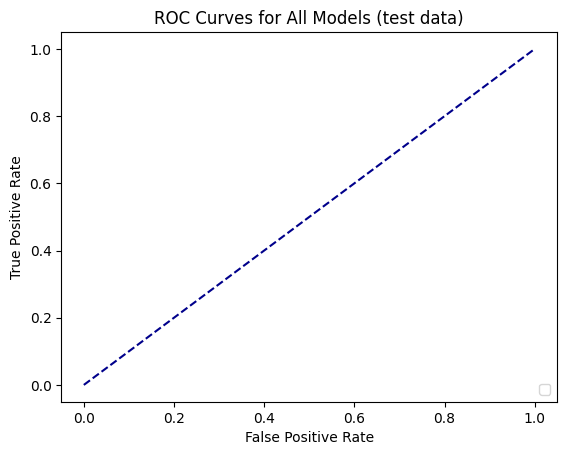

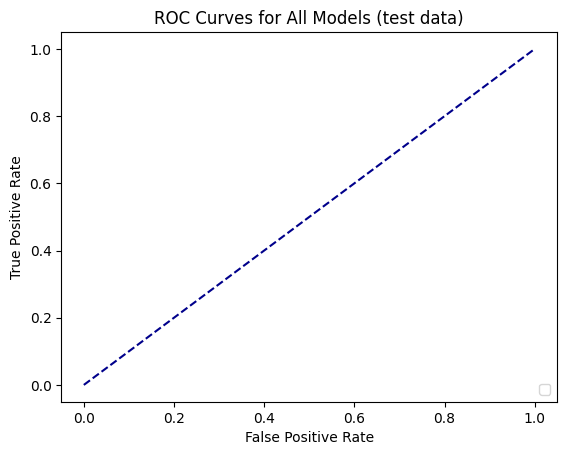

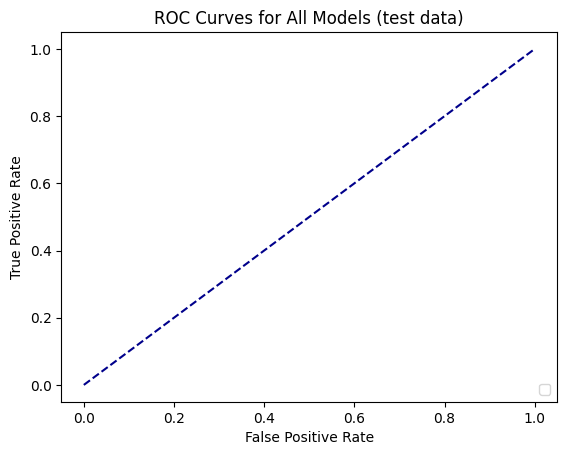

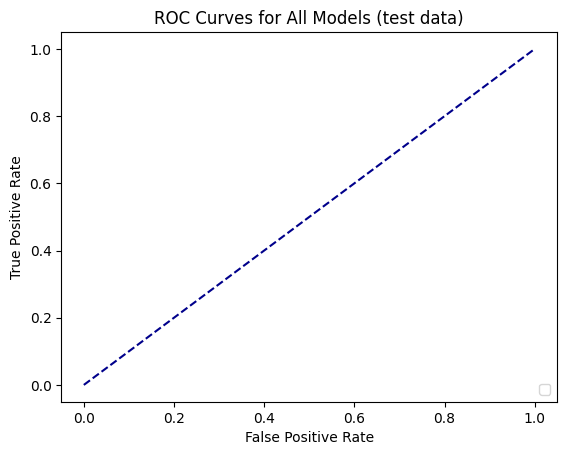

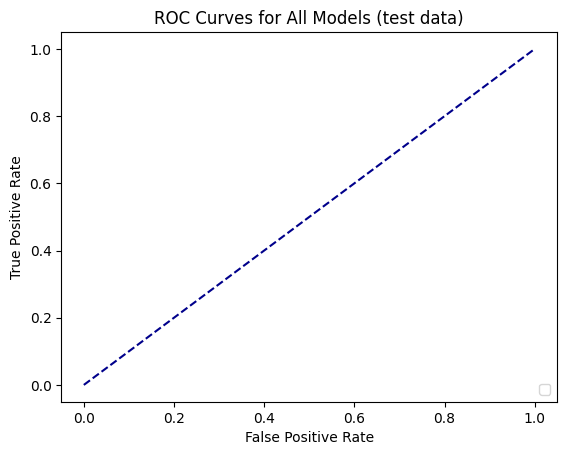

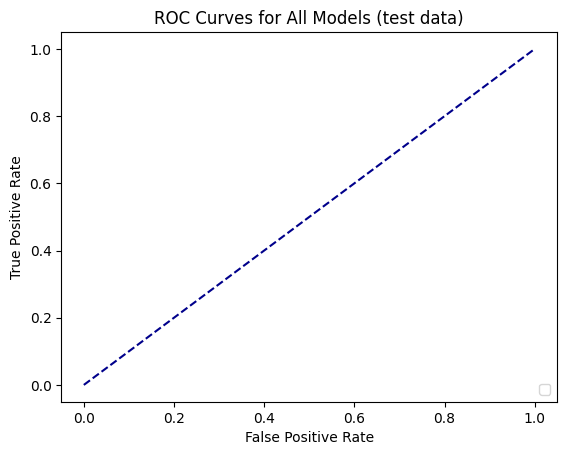

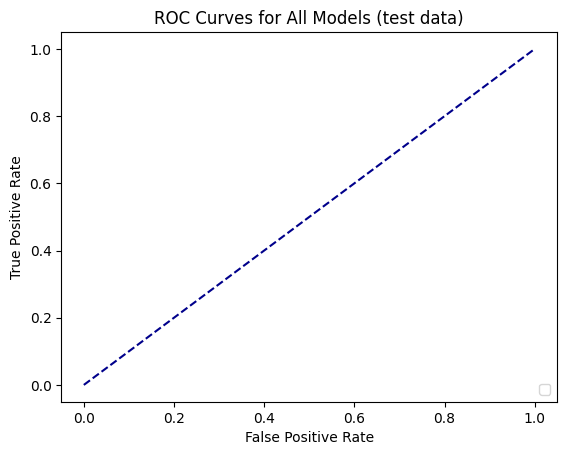

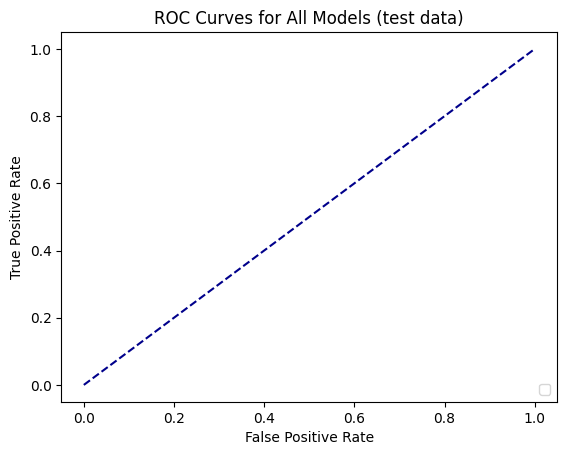

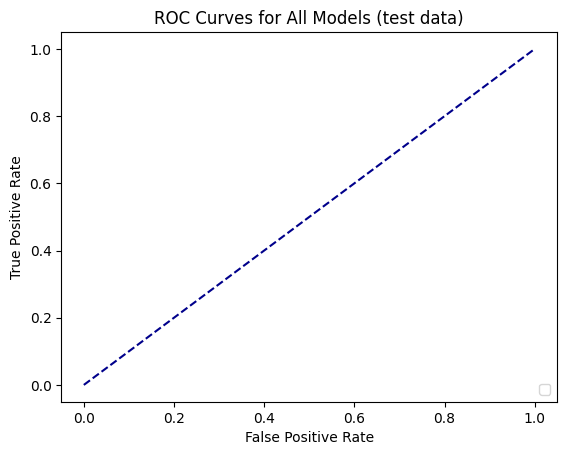

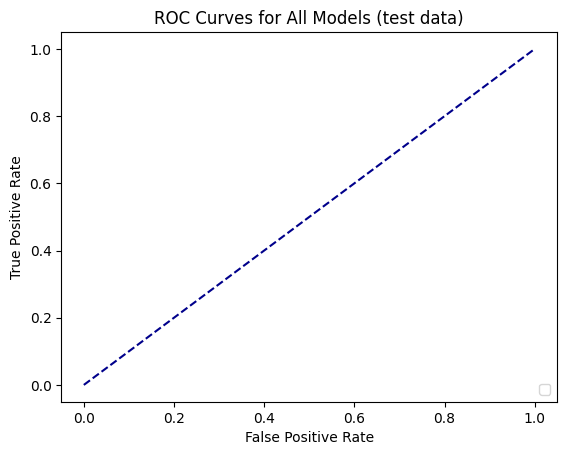

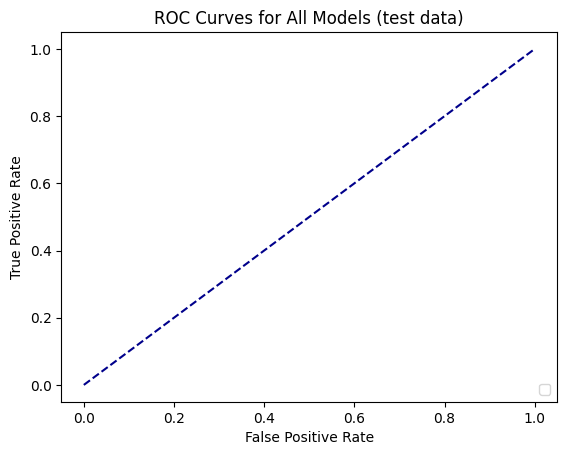

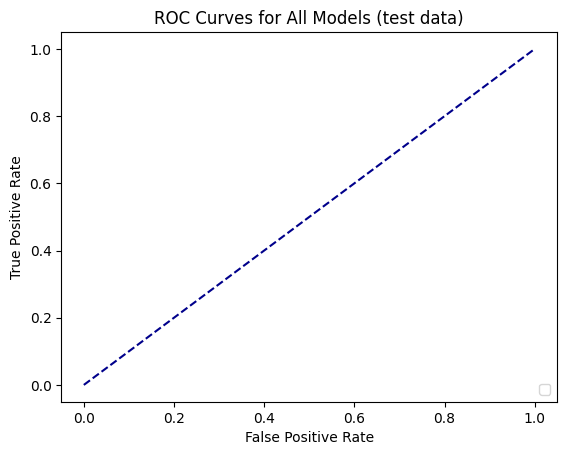

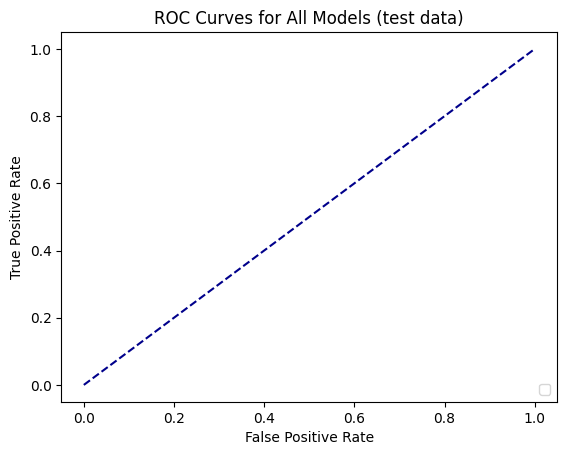

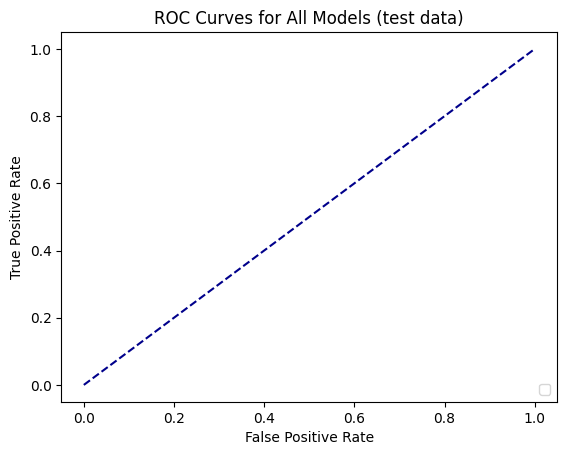

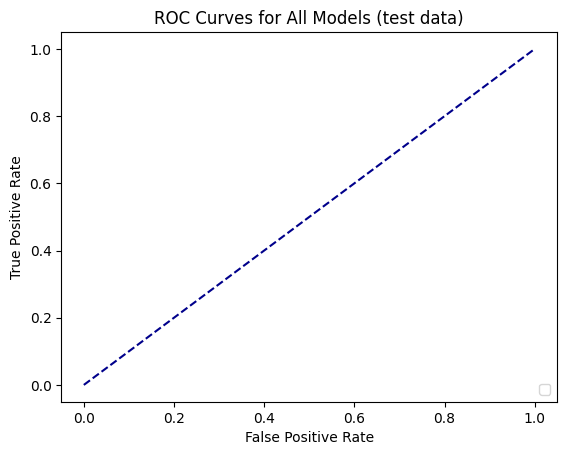

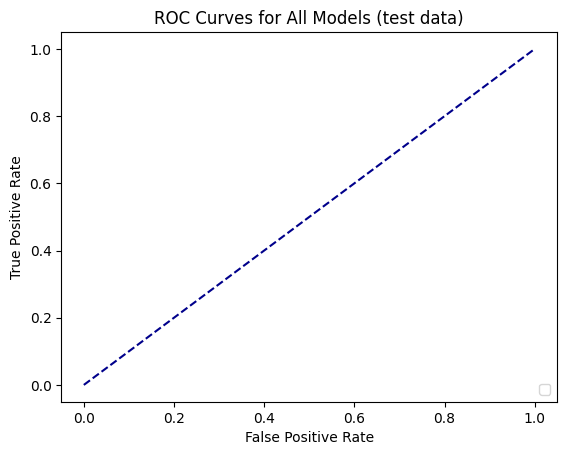

In [78]:
results_blocks = get_results_blocks(model_map, X_cats_dogs, Y_cats_dogs, flag=False, key='blocks', flag_plot=False, prints=False)
# for i in range(len(results_blocks)):
#     print(f"Feature importance for block {i}...")
#     plot_feature_importance(results_blocks[i]['results'], pd.DataFrame(results_blocks[i]['block']), Y_cats_dogs, key='block_{i}', dim=16, sample_image=mean_cat_image)

In [79]:
top_3_blocks = get_top_blocks(results_blocks, 6)

Top Block 1 with highest F1 score:
Best F1 Score: 0.8465473145780051
Additional information about the best model:
Experiment: block_10
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7532656023222061
Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.8465473145780051
--------------------------------------------------

Top Block 2 with highest F1 score:
Best F1 Score: 0.84375
Additional information about the best model:
Experiment: block_11
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7148040638606675
Model: Support Vector Machine, test accuracy score: 0.85, test f1 Score: 0.84375
--------------------------------------------------

Top Block 3 with highest F1 score:
Best F1 Score: 0.819471308833011
Additional information about the best model:
Experiment: block_5
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'r

### 2.c Results for flipped images

2024-05-22 18:28:43,193 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


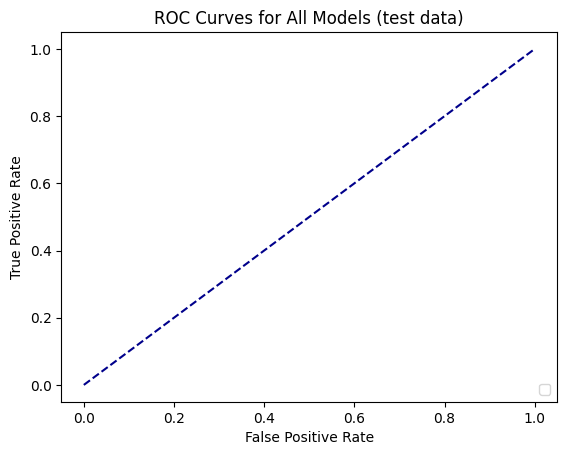

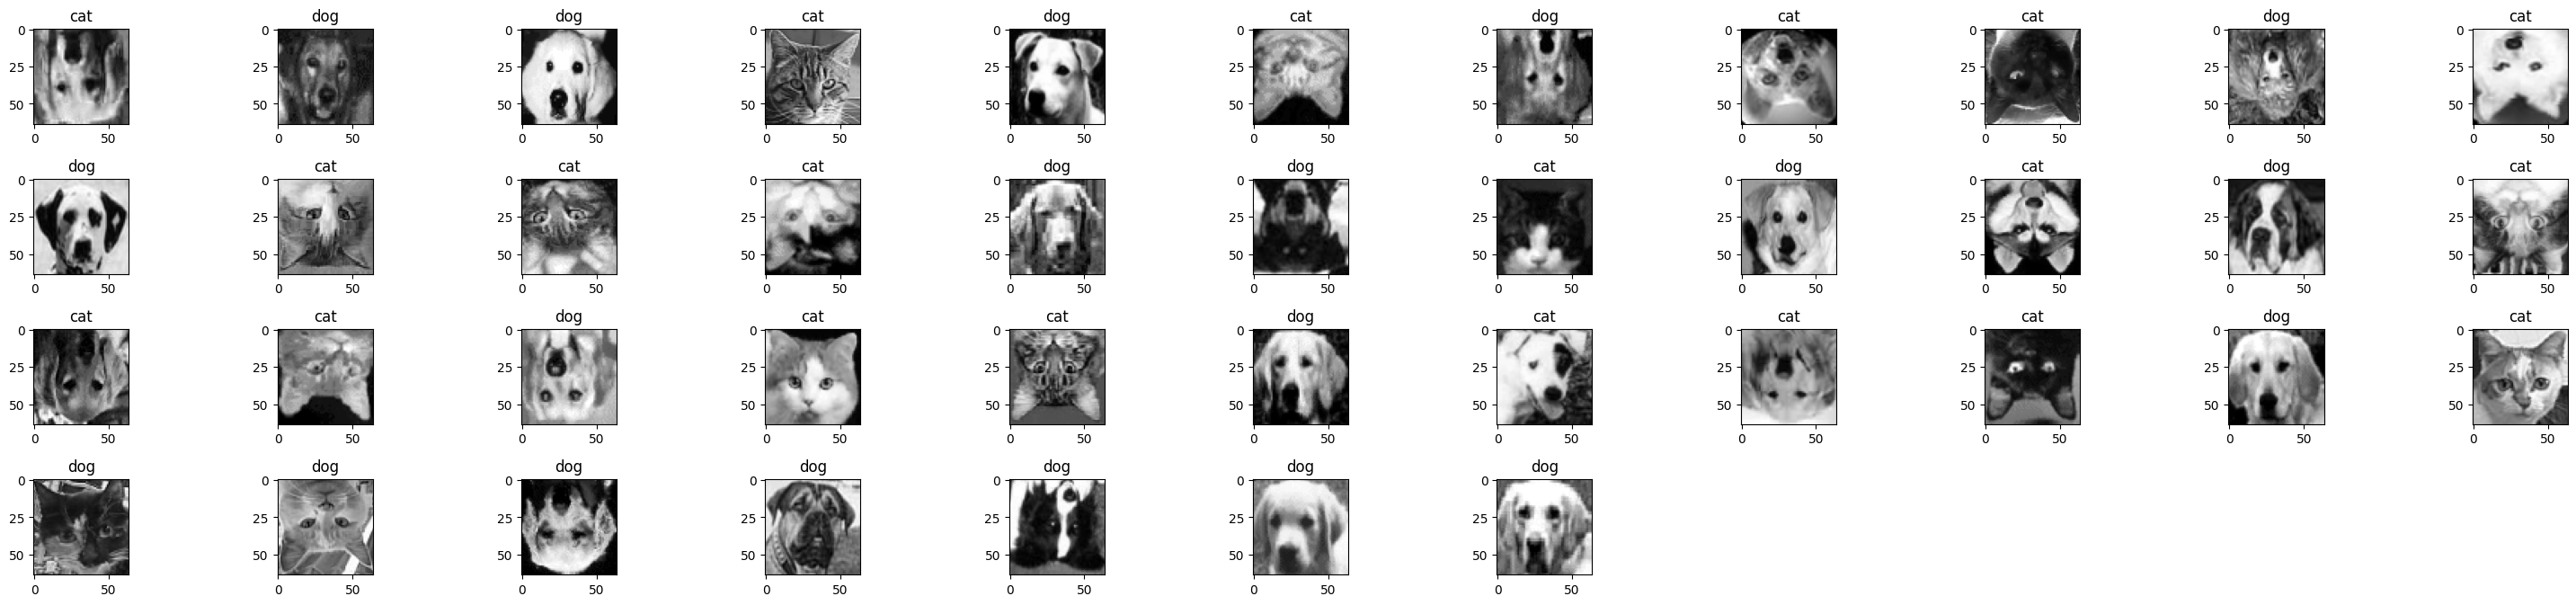

In [126]:
###################### To answer the questions (just one run) #####################################
X_flipped = pd.DataFrame(flip_half_images_upside_down(X_cats_dogs, Y_cats_dogs))
results_flipped, best_model_flipped = main_parallel(model_map, X_flipped, Y_cats_dogs, key='flipped', flag_plot=False, prints=False, best_model_metric='f1_score')   
#mean_cat_image, mean_dog_image = mean_animal(X_cats_dogs, Y_cats_dogs)

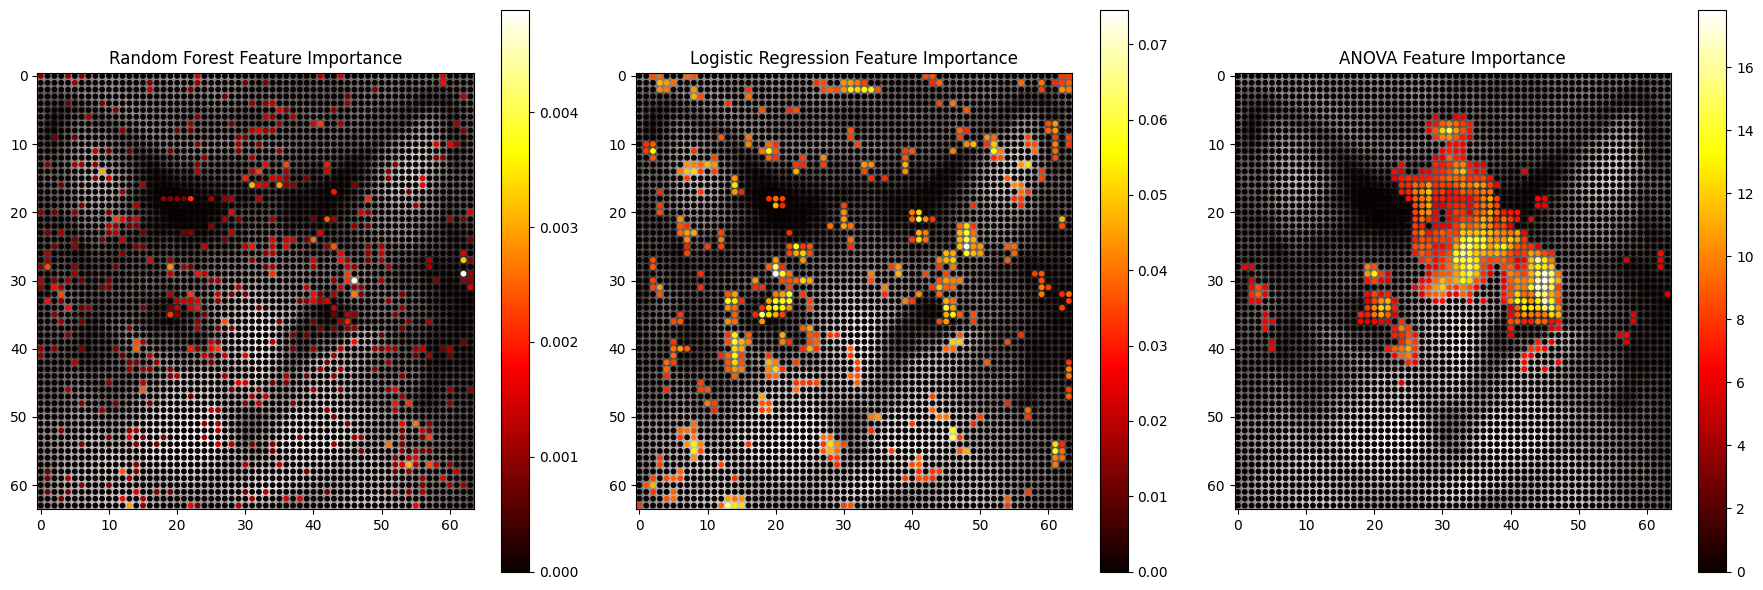

In [97]:
plot_feature_importance(results_flipped, X_flipped, Y_cats_dogs, key='flipped', dim=64, sample_image=mean_cat_image, n_best=500)

c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

---------------------------------------------------------------------------------------------------
Total mislabeling across all models
---------------------------------------------------------------------------------------------------
Mislabeled indices: [(14, 46), (71, 44), (175, 43), (139, 43), (176, 42)]


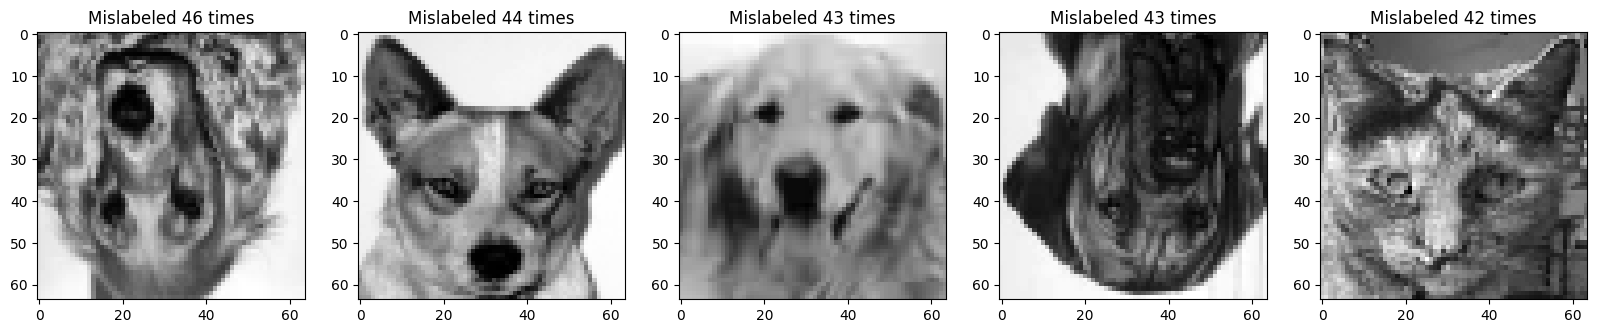

---------------------------------------------------------------------------------------------------
Mislabeling for each model
---------------------------------------------------------------------------------------------------
Mislabeling for model: knn
Mislabeled indices: [(5, 10), (9, 10), (30, 10), (66, 10), (78, 10)]


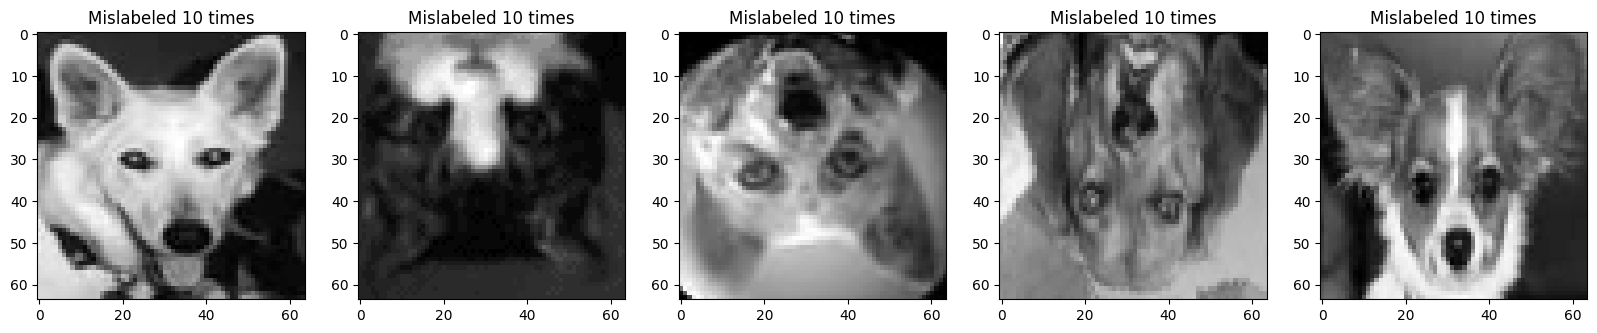

---------------------------------------------------------------------------------------------------
Mislabeling for model: lr
Mislabeled indices: [(60, 10), (65, 10), (75, 10), (85, 10), (175, 10)]


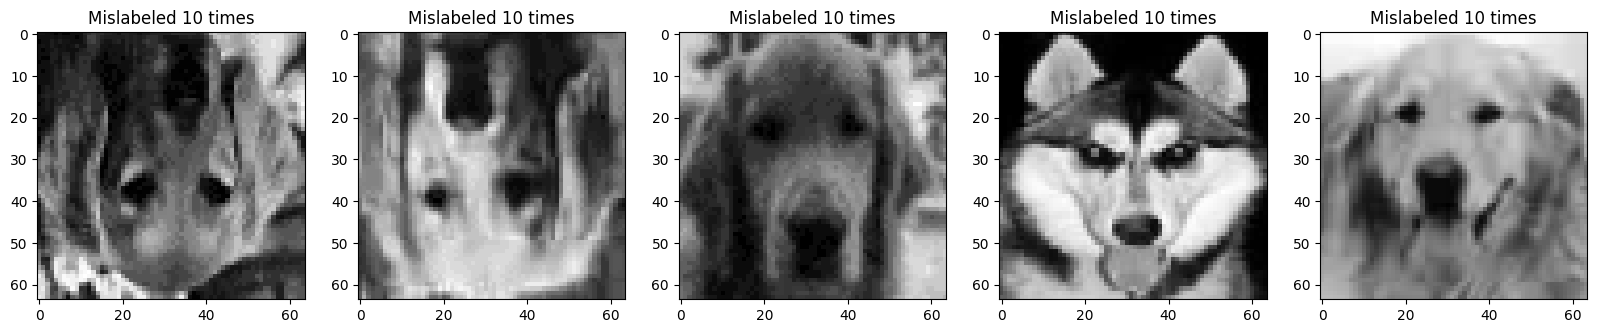

---------------------------------------------------------------------------------------------------
Mislabeling for model: svm
Mislabeled indices: [(9, 10), (60, 10), (65, 10), (175, 10), (25, 10)]


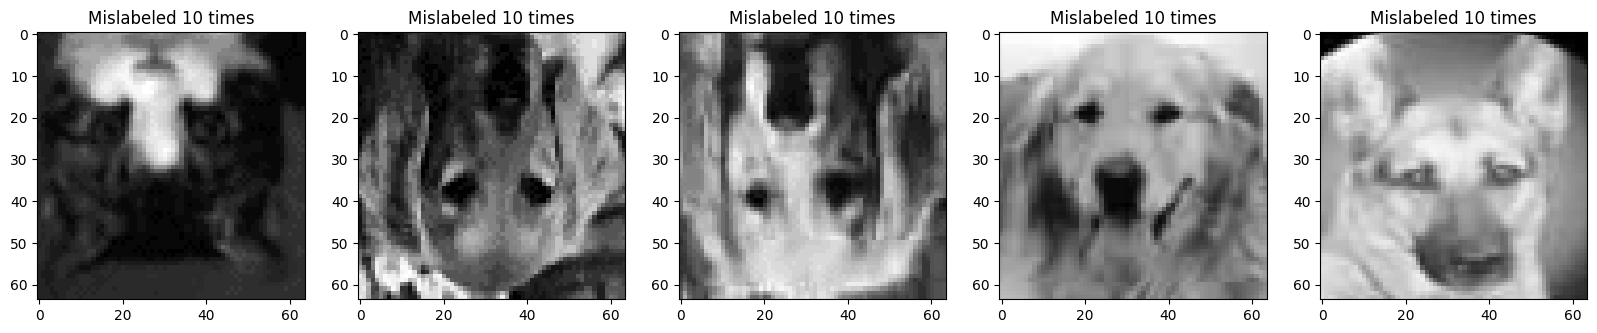

---------------------------------------------------------------------------------------------------
Mislabeling for model: rf
Mislabeled indices: [(12, 10), (139, 10), (176, 10), (192, 10), (14, 10)]


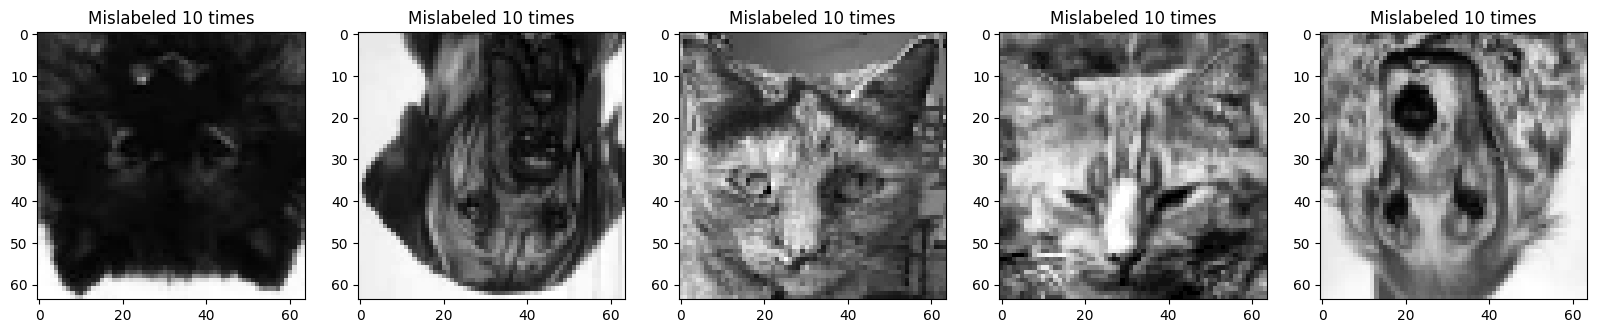

---------------------------------------------------------------------------------------------------
Mislabeling for model: mlp
Mislabeled indices: [(69, 9), (24, 8), (115, 8), (125, 8), (101, 8)]


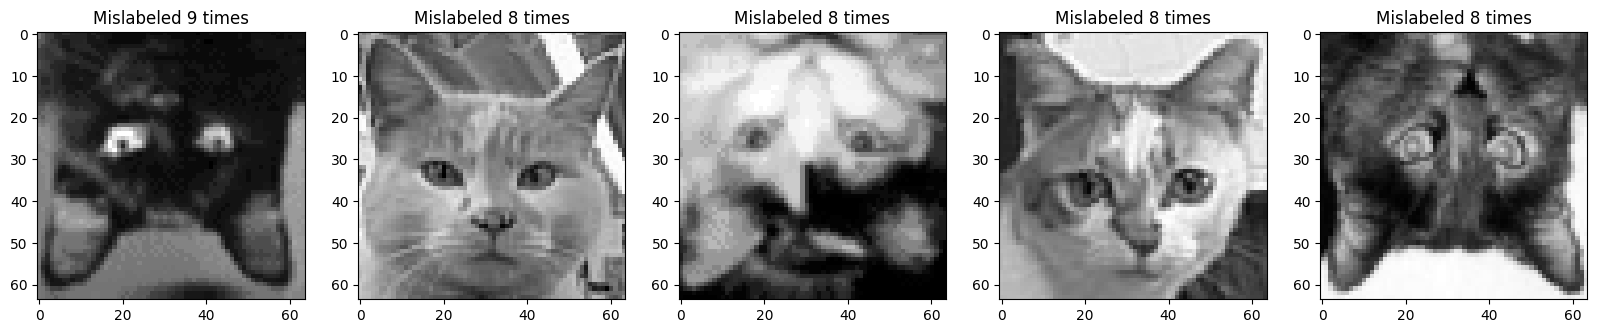

---------------------------------------------------------------------------------------------------
Images mislabeled by models - count the number of models that mislabeled the top 10 images for each model
---------------------------------------------------------------------------------------------------
Mislabeled indices: [(175, 4), (9, 2), (85, 2), (25, 2), (60, 2)]


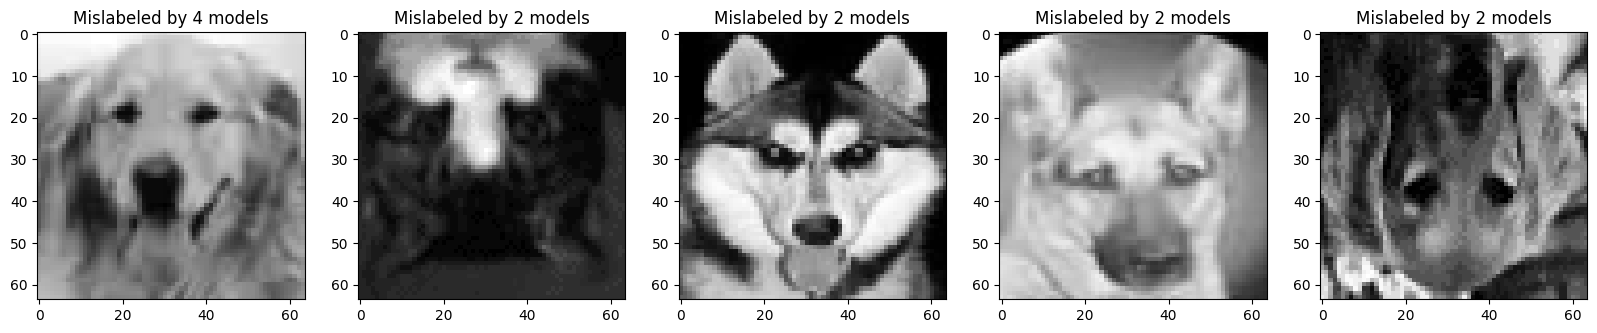

In [104]:
mislabeled_images(results_flipped, X_flipped, Y_cats_dogs)

2024-05-22 16:55:36,343 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-05-22 16:56:02,253 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-05-22 16:56:26,766 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-05-22 16:56:46,600 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-05-22 16:57:07,133 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-05-22 16:57:27,104 - WARNING -

Flipped Images - 20 runs: {'mean_test_accuracy': 0.80625, 'mean_test_f1_score': 0.8003432322683313}


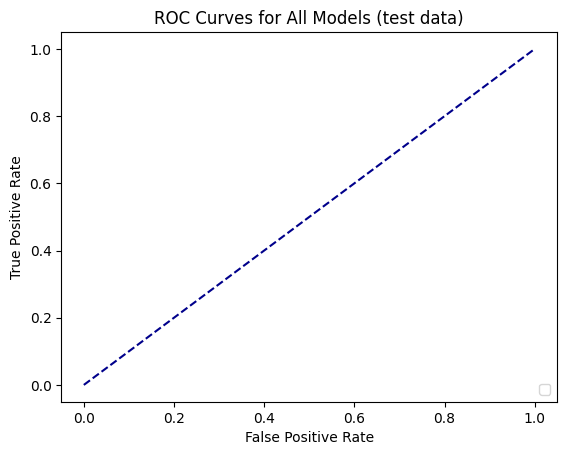

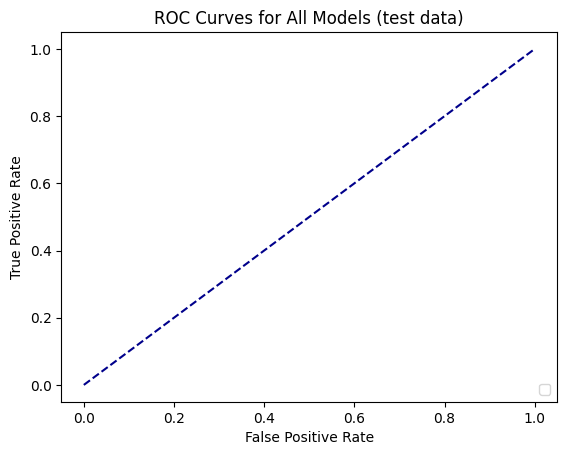

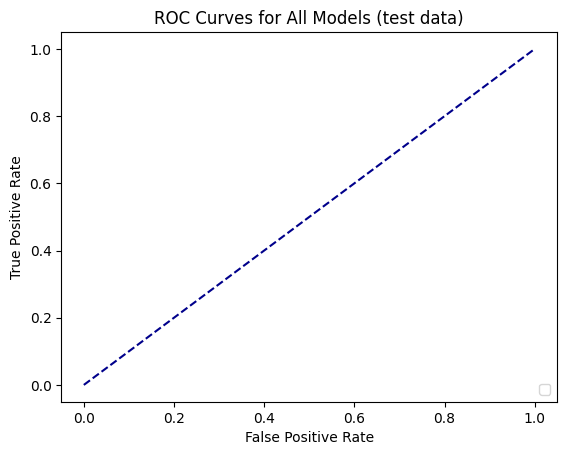

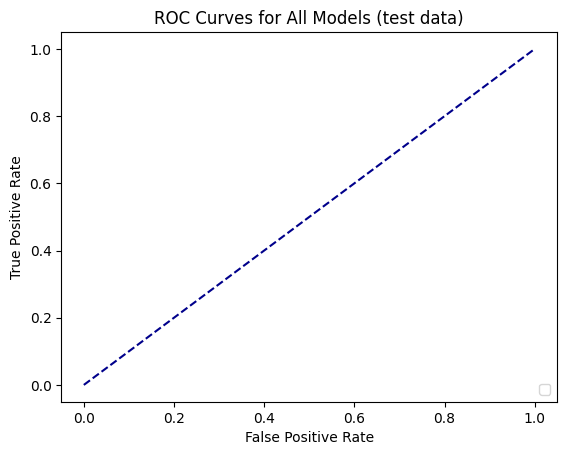

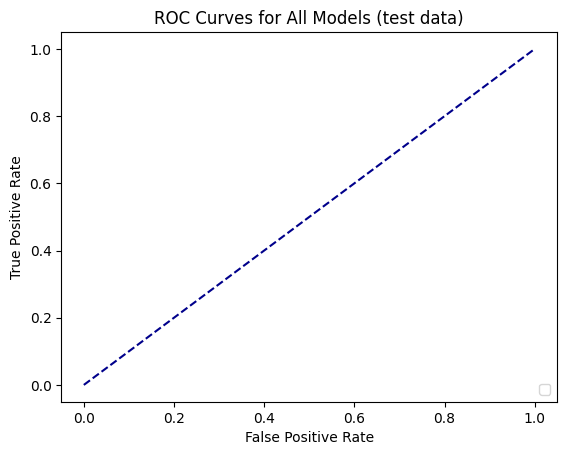

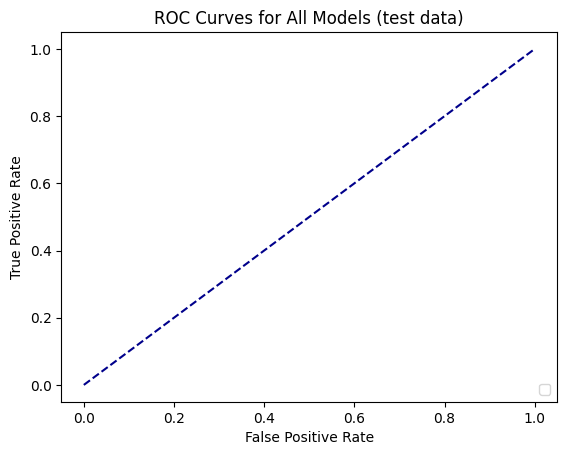

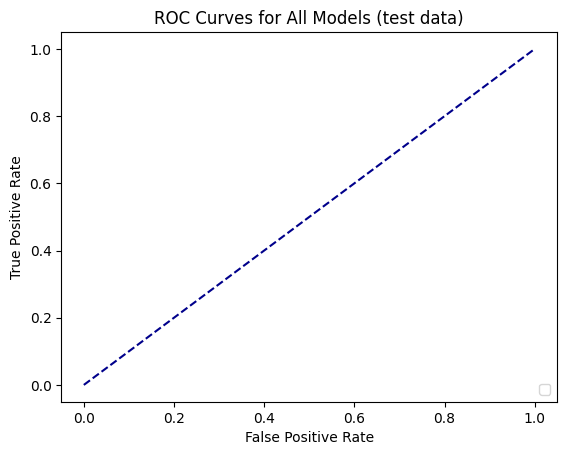

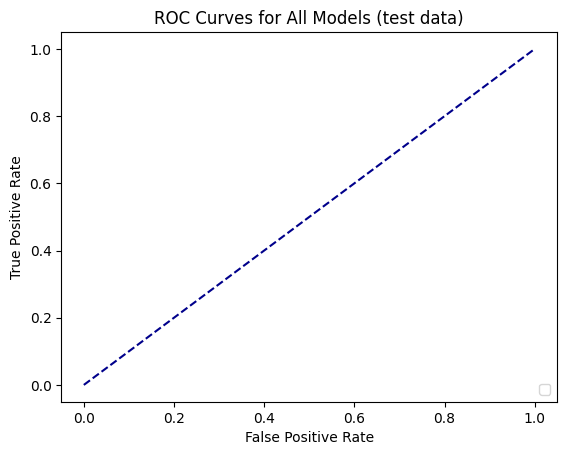

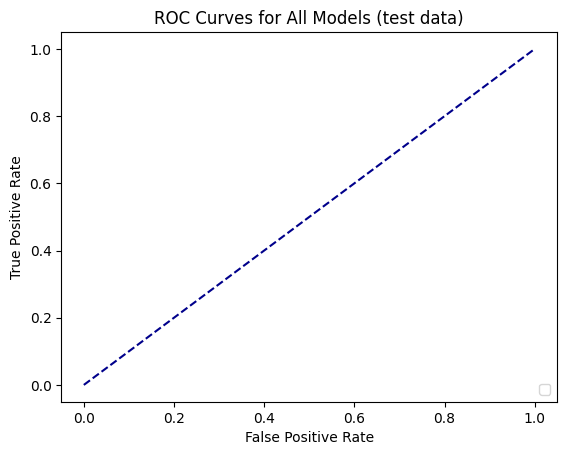

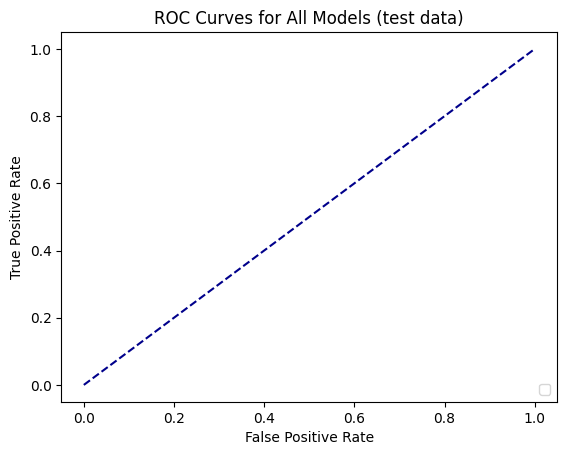

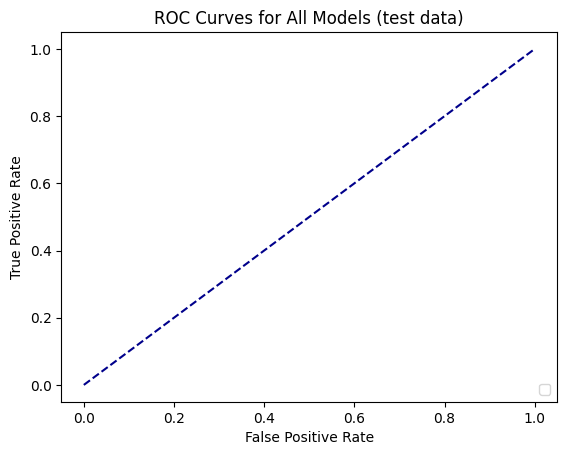

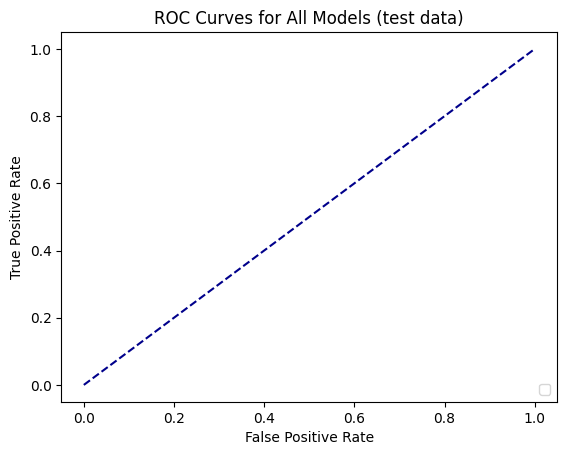

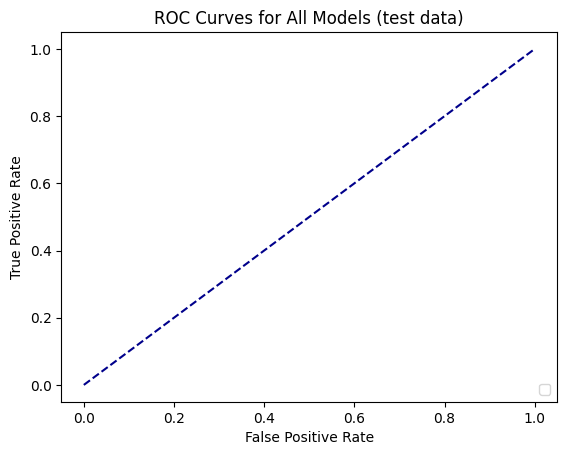

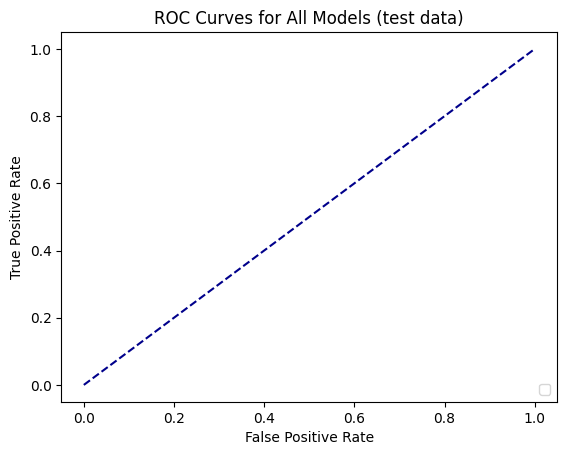

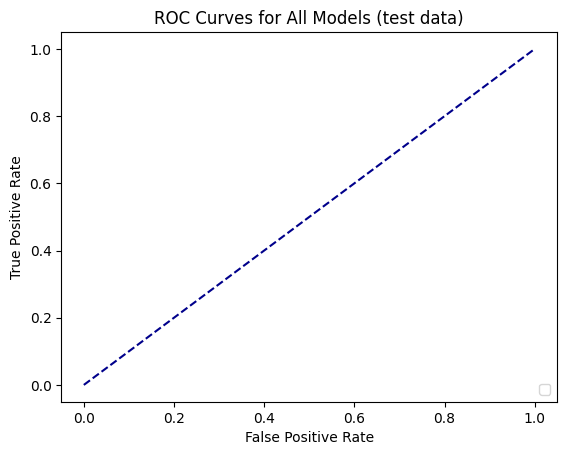

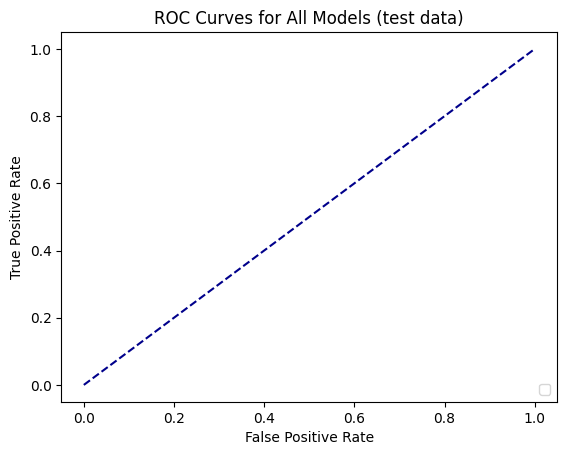

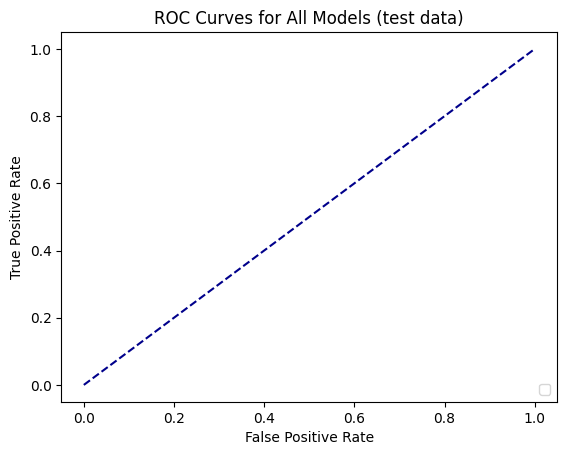

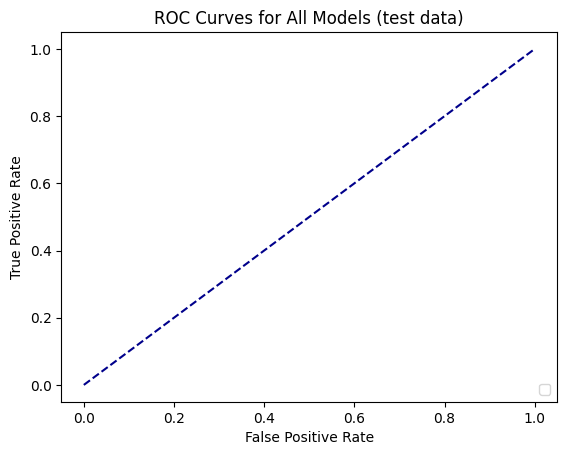

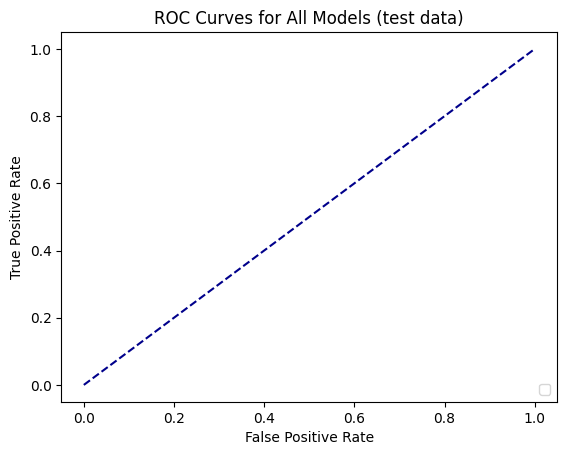

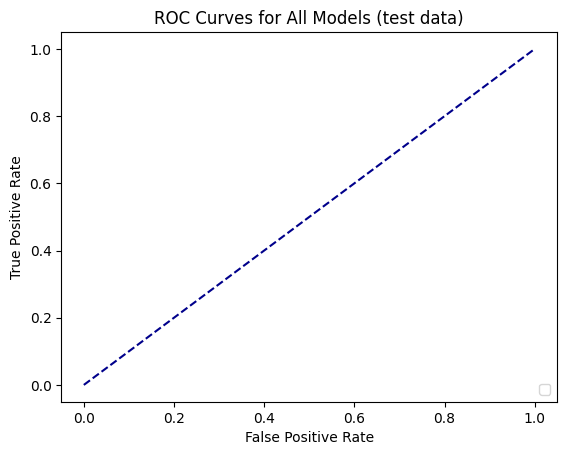

In [101]:
def flipped_runs(model_map, X, Y, key, image, num_runs=5, flag_plot=False, prints=False, best_model_metric='f1_score'):
    all_results = []  # Store results for all runs

    for _ in range(num_runs):
        X_flipped = pd.DataFrame(flip_half_images_upside_down(X, Y))
        _, best_model = main_parallel(model_map, X_flipped, Y, key=key, flag_plot=flag_plot, prints=prints, best_model_metric=best_model_metric)
        all_results.append({
            'test_accuracy': best_model['test_accuracy'],
            'test_f1_score': best_model['test_f1_score']
            })

    flipped_runs_means = {'mean_test_accuracy': np.mean([result['test_accuracy'] for result in all_results]),
                          'mean_test_f1_score': np.mean([result['test_f1_score'] for result in all_results])}
    
    print(f"Flipped Images - {num_runs} runs: {flipped_runs_means}")

    return flipped_runs_means

mean_cat_image, mean_dog_image = mean_animal(X_cats_dogs, Y_cats_dogs)
flipped_runs_means = flipped_runs(model_map, X_cats_dogs, Y_cats_dogs, key='flipped', image=mean_cat_image, num_runs=20)


In [81]:
# X_cats_dogs_flipped = pd.DataFrame(flip_half_images_upside_down(X_cats_dogs, Y_cats_dogs))
# results_flipped, best_model_flipped = main_parallel(model_map, X_cats_dogs_flipped, Y_cats_dogs, key='flipped', prints=False)
# plot_feature_importance(results_flipped, X_cats_dogs, Y_cats_dogs, key='flipped', dim=64)
# plot_images(data=X_cats_dogs_flipped, labels=Y_cats_dogs, label_names={0: "cat", 1: "dog"}, key_='flipped')